<a href="https://colab.research.google.com/github/MehrdadGh1989/Stochastic-Modeling-Wind-Speed-Power/blob/main/Codes_Second_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Wind Speed Simulation by SDEs Models - Wind Power Estimation By trained ML model - Probability Analysis

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/Kelmarsh Wind Turbine')
!ls

Mounted at /content/drive
AAPL_2020_2023_3.csv	      sarimax_forecast.png
best_sdenet1_model.pth	      sdenet1_model_100epochs.pth
future_predictions.csv	      sigma_heatmap_january.png
hourly_kappa_january.csv      simulated_wind_speed.csv
hourly_mae_january.csv	      T1_Kelmarsh_2017.csv
hourly_mse_january.csv	      T1_Kelmarsh_2018.csv
hourly_sigma_january.csv      T1_Kelmarsh_2019.csv
kappa_heatmap_january.png     T1_Kelmarsh_2020.csv
kelmarsh_wind_map.html	      T1_Kelmarsh_2021_6Months.csv
kelmarsh_wind_speed_map.html  time_dependent_params.png
mae_heatmap_january.png       Wind_Atlas_Kelmarsh_2017.0.html
mse_heatmap_january.png       Wind_Atlas_Kelmarsh_2018.0.html
power_academic_plot.png       wind_speed_academic_plot.png
sarimax_diagnostics.png       wind_speed_comparisons.png


In [ ]:
# ===================== Standard Library =====================
import argparse
import datetime as dt
import logging
import math
import os
import random
import time
import warnings
from collections import namedtuple
from typing import Optional, Union

# ===================== Numerical & Data =====================
import numpy as np
import pandas as pd

# ===================== Visualization =====================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib import rcParams
import seaborn as sns

# ===================== Machine Learning =====================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

import xgboost as xgb

# ===================== Statistics & Time Series =====================
from scipy.stats import (
    levy_stable,
    weibull_min,
    skew,
    kurtosis
)
from scipy.special import gamma, gammainc
from scipy.optimize import minimize

from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import acf

# ===================== Utilities =====================
import tqdm


#### Importing Clean Data - 2020 and Preprocessing

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Wind_Turbine_Data/T1_Kelmarsh_Clean.csv')

In [ ]:
data

,Date and time,Wind speed (m/s),Power (kW),Month,Year
0,2017-01-01 00:00:00,7.606060,840.748535,1.0,2017.0
1,2017-01-01 00:10:00,7.813293,886.659973,1.0,2017.0
2,2017-01-01 00:20:00,7.323050,798.429199,1.0,2017.0
3,2017-01-01 00:30:00,7.559484,839.762207,1.0,2017.0
4,2017-01-01 00:40:00,7.502729,853.284729,1.0,2017.0
...,...,...,...,...,...
210379,2020-12-31 23:10:00,5.119444,253.676392,12.0,2020.0
210380,2020-12-31 23:20:00,5.009681,236.046799,12.0,2020.0
210381,2020-12-31 23:30:00,5.060813,245.340683,12.0,2020.0
210382,2020-12-31 23:40:00,4.814269,206.051880,12.0,2020.0


#### Data Visualization - Wind Speed and Wind Power

In [ ]:
# Filter for January (Month == 1)
jan = data[data["Month"] == 1]

# Group by year and calculate averages
yearly_avg = jan.groupby("Year").agg({
    "Wind speed (m/s)": "mean",
    "Power (kW)": "mean"
}).reset_index()

# Color mapping for each year
color_pairs_speed = {
    2017: "greenyellow",
    2018: "royalblue",
    2019: "dimgrey",
    2020: "darkred"
}

color_pairs_power = {
    2017: "yellowgreen",
    2018: "lightsteelblue",
    2019: "silver",
    2020: "indianred"
}


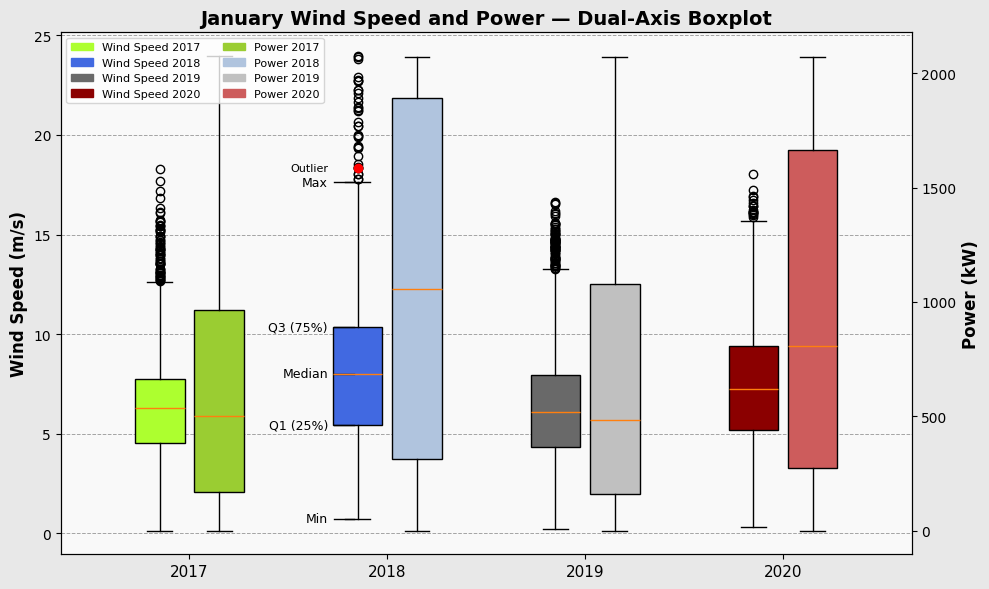

In [ ]:

# Filter January data
jan = data[data["Month"] == 1]
years = [2017, 2018, 2019, 2020]

# Extract data
wind_data = [jan[jan["Year"] == y]["Wind speed (m/s)"] for y in years]
power_data = [jan[jan["Year"] == y]["Power (kW)"] for y in years]

# Colors
speed_colors = ["greenyellow", "royalblue", "dimgrey", "darkred"]
power_colors = ["yellowgreen", "lightsteelblue", "silver", "indianred"]

# X positions
x = np.arange(len(years))
width = 0.30

fig, ax1 = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("#e8e8e8")
ax1.set_facecolor("#f9f9f9")

# --- WIND SPEED BOXPLOTS -------------------------------------------------
wind_pos = x - width/2
bp1 = ax1.boxplot(
    wind_data,
    positions=wind_pos,
    widths=0.25,
    patch_artist=True
)

for patch, color in zip(bp1["boxes"], speed_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")

ax1.set_ylabel("Wind Speed (m/s)", fontsize=12, fontweight="bold")
ax1.yaxis.grid(True, linestyle="--", linewidth=0.7, color="gray", alpha=0.7)
ax1.set_axisbelow(True)

# --- POWER BOXPLOTS ------------------------------------------------------
ax2 = ax1.twinx()
power_pos = x + width/2

bp2 = ax2.boxplot(
    power_data,
    positions=power_pos,
    widths=0.25,
    patch_artist=True
)

for patch, color in zip(bp2["boxes"], power_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")

ax2.set_ylabel("Power (kW)", fontsize=12, fontweight="bold")

# --- X-AXIS --------------------------------------------------------------
ax1.set_xticks(x)
ax1.set_xticklabels(years, fontsize=11)
plt.title("January Wind Speed and Power — Dual-Axis Boxplot", fontsize=14, fontweight="bold")

# --- LEGEND --------------------------------------------------------------
import matplotlib.patches as mpatches
legend_elements = [
    mpatches.Patch(color="greenyellow", label="Wind Speed 2017"),
    mpatches.Patch(color="royalblue", label="Wind Speed 2018"),
    mpatches.Patch(color="dimgrey", label="Wind Speed 2019"),
    mpatches.Patch(color="darkred", label="Wind Speed 2020"),
    mpatches.Patch(color="yellowgreen", label="Power 2017"),
    mpatches.Patch(color="lightsteelblue", label="Power 2018"),
    mpatches.Patch(color="silver", label="Power 2019"),
    mpatches.Patch(color="indianred", label="Power 2020"),
]
plt.legend(handles=legend_elements, loc="upper left", fontsize=8, ncol=2)

# ==========================================================================
#   ANNOTATE ONE SELECTED WIND SPEED BOXPLOT (LEFT-ALIGNED TEXT)
# ==========================================================================

selected_index = 1   # 0=2017, 1=2018, 2=2019, 3=2020
selected_year = years[selected_index]

# Extract stats
data_sel = wind_data[selected_index]
Q1 = np.percentile(data_sel, 25)
median = np.percentile(data_sel, 50)
Q3 = np.percentile(data_sel, 75)
IQR = Q3 - Q1
lower_whisker = np.min(data_sel[data_sel >= Q1 - 1.5*IQR])
upper_whisker = np.max(data_sel[data_sel <= Q3 + 1.5*IQR])

outliers = data_sel[(data_sel < Q1 - 1.5*IQR) | (data_sel > Q3 + 1.5*IQR)]

xpos = wind_pos[selected_index]

# Annotating function (LEFT side)
def annotate_left(y, label):
    ax1.plot([xpos - 0.12, xpos - 0.02], [y, y], color="black", linewidth=1)
    ax1.text(xpos - 0.15, y, label, fontsize=9, va="center", ha="right")

annotate_left(lower_whisker, "Min")
annotate_left(Q1, "Q1 (25%)")
annotate_left(median, "Median")
annotate_left(Q3, "Q3 (75%)")
annotate_left(upper_whisker, "Max")

# Only write “Outlier” once
if len(outliers) > 0:
    o = outliers.iloc[0]
    ax1.plot(xpos, o, 'ro', markersize=6)
    ax1.text(xpos - 0.15, o, "Outlier", fontsize=8, ha="right", va="center")

plt.tight_layout()
plt.show()


/tmp/ipython-input-3545191060.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmaps[year], len(group_labels))
/tmp/ipython-input-3545191060.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmaps[year], len(group_labels))
/tmp/ipython-input-3545191060.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmaps[year], len(group_labels))
/tmp/ipython-input-3545191060.py:66: MatplotlibDeprecationWarnin

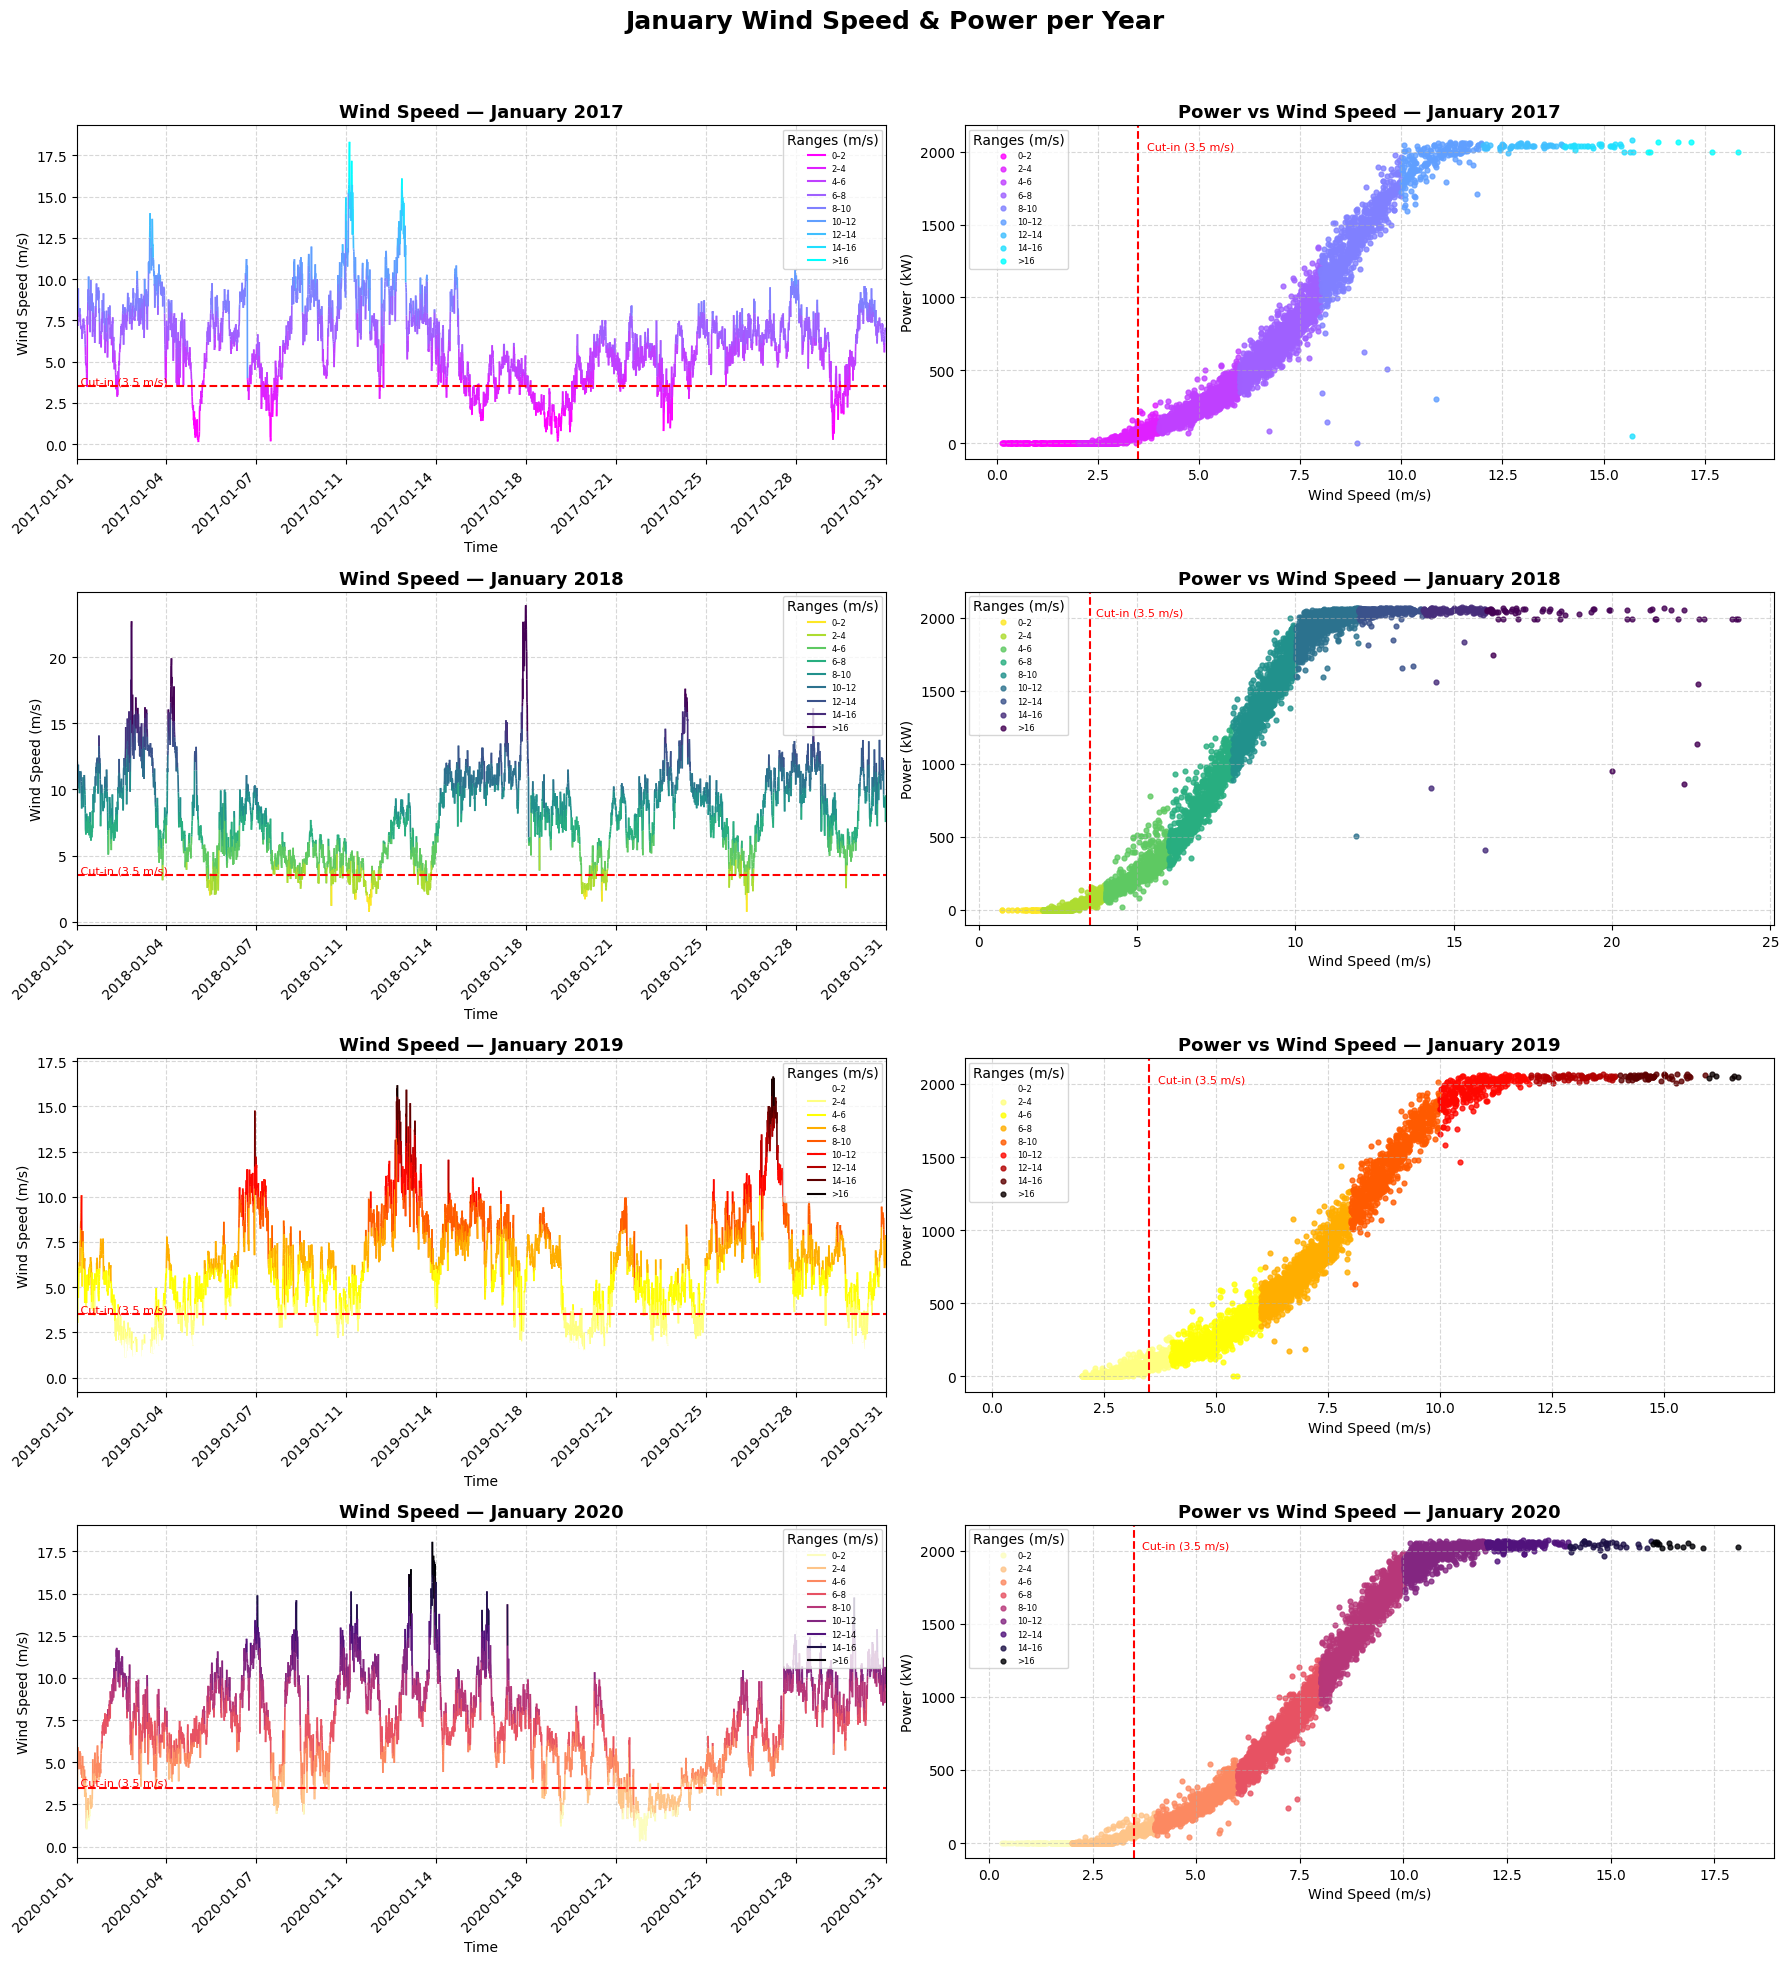

In [ ]:

# Cut-in wind speed (ONLY)
# --------------------------------------------------
cut_in = 3.5

# --------------------------------------------------
# Wind speed groups
# --------------------------------------------------
ranges = {
    "0–2":  (0, 2),
    "2–4":  (2, 4),
    "4–6":  (4, 6),
    "6–8":  (6, 8),
    "8–10": (8, 10),
    "10–12": (10, 12),
    "12–14": (12, 14),
    "14–16": (14, 16),
    ">16":   (16, 50),
}

group_labels = list(ranges.keys())

def assign_group(v):
    for label, (lo, hi) in ranges.items():
        if lo <= v < hi:
            return label
    return None

# --------------------------------------------------
# Years + colormaps
# --------------------------------------------------
years = [2017, 2018, 2019, 2020]

cmaps = {
    2017: "cool",
    2018: "viridis",
    2019: "hot",
    2020: "magma"
}

# --------------------------------------------------
# Figure
# --------------------------------------------------
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
fig.suptitle(
    "January Wind Speed & Power per Year",
    fontsize=18,
    fontweight="bold"
)

# --------------------------------------------------
# Process each year
# --------------------------------------------------
for row, year in enumerate(years):

    subset = data[(data["Month"] == 1) & (data["Year"] == year)].copy()
    subset["Date and time"] = pd.to_datetime(subset["Date and time"])
    subset = subset.sort_values("Date and time")

    x_datetime = subset["Date and time"].values
    wind_speed = subset["Wind speed (m/s)"].values
    x_numeric = np.arange(len(x_datetime))

    groups = np.array([assign_group(v) for v in wind_speed])

    # Colormap
    cmap = cm.get_cmap(cmaps[year], len(group_labels))
    N = len(group_labels)
    colors = {group_labels[i]: cmap(N - 1 - i) for i in range(N)}

    # Line segments
    segments, seg_colors = [], []
    for i in range(len(x_numeric) - 1):
        segments.append([
            (x_numeric[i], wind_speed[i]),
            (x_numeric[i + 1], wind_speed[i + 1])
        ])
        seg_colors.append(colors[groups[i]])

    lc = LineCollection(segments, colors=seg_colors, linewidth=1.2)

    # --------------------------------------------------
    # LEFT: Wind Speed vs Time
    # --------------------------------------------------
    ax1 = axes[row, 0]
    ax1.add_collection(lc)
    ax1.set_xlim(x_numeric.min(), x_numeric.max())
    ax1.set_ylim(min(wind_speed.min(), cut_in) - 1, wind_speed.max() + 1)

    tick_pos = np.linspace(0, len(x_numeric) - 1, 10).astype(int)
    tick_labels = [pd.Timestamp(x_datetime[i]).strftime('%Y-%m-%d') for i in tick_pos]
    ax1.set_xticks(tick_pos)
    ax1.set_xticklabels(tick_labels, rotation=45, ha='right')

    ax1.set_title(
        f"Wind Speed — January {year}",
        fontsize=13,
        fontweight="bold"
    )
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Wind Speed (m/s)")
    ax1.grid(True, linestyle="--", alpha=0.5)

    # Cut-in line
    ax1.axhline(cut_in, linestyle="--", linewidth=1.5, color="red")
    ax1.text(
        x_numeric.min(), cut_in,
        " Cut-in (3.5 m/s)",
        fontsize=8,
        va="bottom",
        color="red"
    )

    for label in group_labels:
        ax1.plot([], [], color=colors[label], label=label)
    ax1.legend(title="Ranges (m/s)", fontsize=6)

    # --------------------------------------------------
    # RIGHT: Power vs Wind Speed
    # --------------------------------------------------
    ax2 = axes[row, 1]

    for label in group_labels:
        mask = (groups == label)
        sub = subset[mask]
        ax2.scatter(
            sub["Wind speed (m/s)"],
            sub["Power (kW)"],
            s=12,
            alpha=0.8,
            color=colors[label],
            label=label
        )

    ax2.set_title(
        f"Power vs Wind Speed — January {year}",
        fontsize=13,
        fontweight="bold"
    )
    ax2.set_xlabel("Wind Speed (m/s)")
    ax2.set_ylabel("Power (kW)")
    ax2.grid(True, linestyle="--", alpha=0.5)

    # Cut-in vertical line (horizontal text)
    ax2.axvline(cut_in, linestyle="--", linewidth=1.5, color="red")
    ax2.text(
        cut_in + 0.2,
        ax2.get_ylim()[1] * 0.95,
        "Cut-in (3.5 m/s)",
        fontsize=8,
        color="red",
        ha="left",
        va="top"
    )

    ax2.legend(title="Ranges (m/s)", fontsize=6)

# --------------------------------------------------
# Layout
# --------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


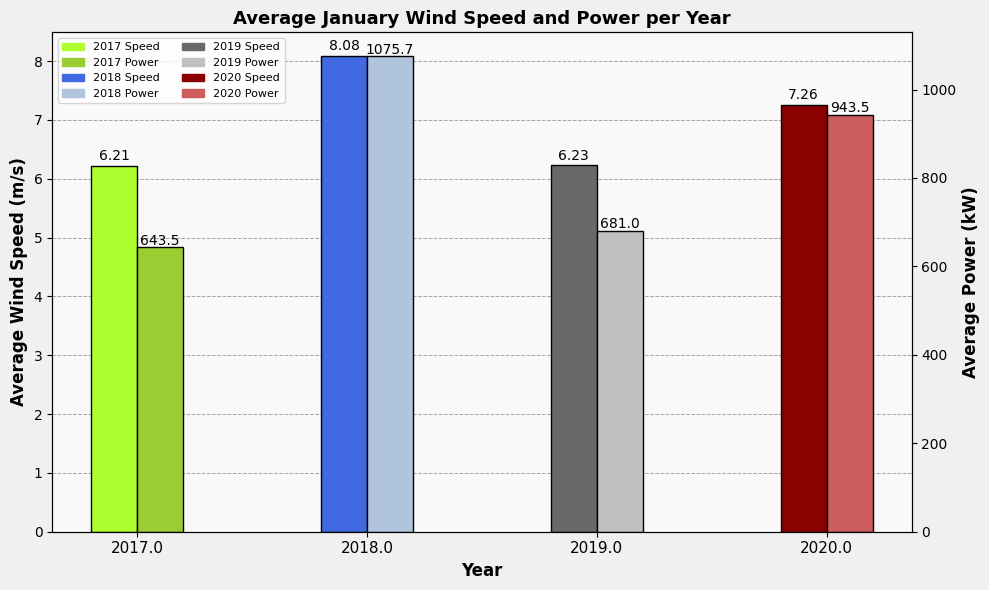

In [ ]:


x = np.arange(len(yearly_avg["Year"]))
width = 0.2


fig, ax1 = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#f0f0f0')
ax1.set_facecolor('#f9f9f9')

bars1 = []
for i, year in enumerate(yearly_avg["Year"]):
    value = yearly_avg.loc[i, "Wind speed (m/s)"]
    b = ax1.bar(
        x[i] - width/2,
        value,
        width,
        color=color_pairs_speed.get(year, 'gray'),
        edgecolor='black'
    )

    ax1.text(x[i] - width/2, value + 0.1, f'{value:.2f}', ha='center', fontsize=10)
    bars1.append(b)

ax1.set_ylabel("Average Wind Speed (m/s)", fontsize=12, fontweight='bold')
ax1.set_xlabel("Year", fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(yearly_avg["Year"], fontsize=11)


ax2 = ax1.twinx()
bars2 = []
for i, year in enumerate(yearly_avg["Year"]):
    value = yearly_avg.loc[i, "Power (kW)"]
    b = ax2.bar(
        x[i] + width/2,
        value,
        width,
        color=color_pairs_power.get(year, 'gray'),
        edgecolor='black'
    )

    ax2.text(x[i] + width/2, value + 5, f'{value:.1f}', ha='center', fontsize=10)
    bars2.append(b)

ax2.set_ylabel("Average Power (kW)", fontsize=12, fontweight='bold')


ax1.yaxis.grid(True, linestyle='--', linewidth=0.7, color='gray', alpha=0.7)
ax1.set_axisbelow(True)


plt.title("Average January Wind Speed and Power per Year", fontsize=13, fontweight='bold')


import matplotlib.patches as mpatches
legend_elements = [
    mpatches.Patch(color='greenyellow', label='2017 Speed'),
    mpatches.Patch(color='yellowgreen', label='2017 Power'),
    mpatches.Patch(color='royalblue', label='2018 Speed'),
    mpatches.Patch(color='lightsteelblue', label='2018 Power'),
    mpatches.Patch(color='dimgrey', label='2019 Speed'),
    mpatches.Patch(color='silver', label='2019 Power'),
    mpatches.Patch(color='darkred', label='2020 Speed'),
    mpatches.Patch(color='indianred', label='2020 Power')
]
plt.legend(handles=legend_elements, loc="upper left", ncol=2, fontsize=8)

plt.tight_layout()
plt.show()


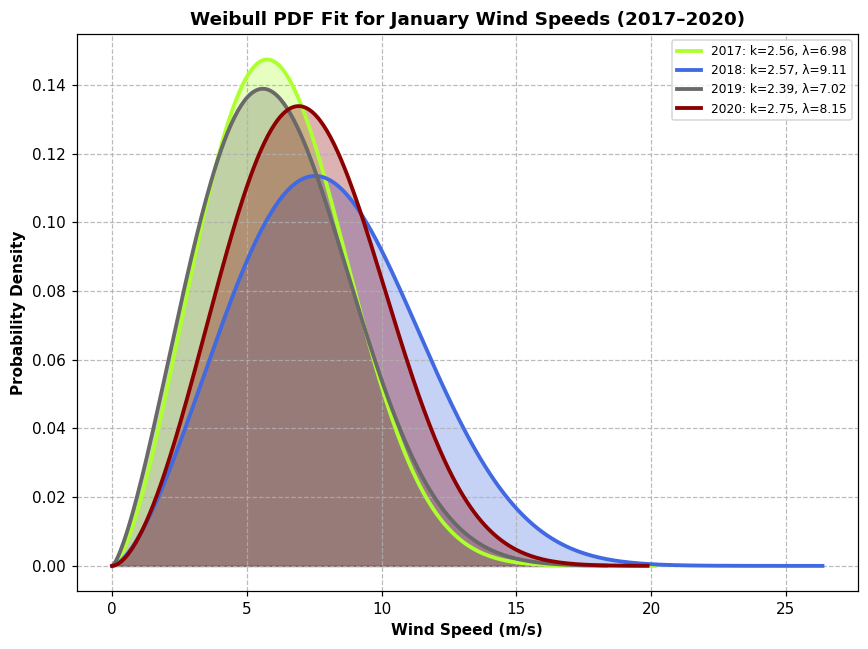

In [ ]:


# Convert 'Date and time' to datetime if not already
data['Date and time'] = pd.to_datetime(data['Date and time'])

# Filter only January data
jan_data = data[data['Month'] == 1]

# Years and your chosen sequential colors
years = [2017, 2018, 2019, 2020]


colors = ['greenyellow', 'royalblue', 'dimgrey', 'darkred']
weibull_params = {}


plt.figure(figsize=(8, 6), dpi=110)

for year, color in zip(years, colors):
    wind_data = jan_data[jan_data['Year'] == year]['Wind speed (m/s)'].dropna()

    k, loc, lam = weibull_min.fit(wind_data, floc=0)
    weibull_params[year] = (k, lam)


    x_vals = np.linspace(0, wind_data.max() * 1.1, 300)
    pdf_vals = weibull_min.pdf(x_vals, c=k, scale=lam)


    plt.plot(
        x_vals,
        pdf_vals,
        label=f'{year}: k={k:.2f}, λ={lam:.2f}',
        color=color,
        linewidth=2.5
    )


    plt.fill_between(
        x_vals,
        pdf_vals,
        color=color,
        alpha=0.30
    )

# Styling
plt.title('Weibull PDF Fit for January Wind Speeds (2017–2020)', fontsize=12, weight='bold')
plt.xlabel('Wind Speed (m/s)', fontsize=10, weight='bold')
plt.ylabel('Probability Density', fontsize=10, weight='bold')
plt.grid(True, linestyle='--', alpha=0.85)
plt.legend(fontsize=8, frameon=True)
plt.tight_layout()

plt.show()

In [ ]:

# Assuming your dataset is already loaded into a DataFrame named 'data'
# Make sure 'Month' and 'Year' are integers
data['Month'] = data['Month'].astype(int)
data['Year'] = data['Year'].astype(int)

# Step 1: Group by Year and Month, and sum the power
monthly_power = data.groupby(['Year', 'Month'])['Power (kW)'].sum().reset_index()

# Step 2: Compute total power per year
yearly_power = monthly_power.groupby('Year')['Power (kW)'].sum().reset_index()
yearly_power = yearly_power.rename(columns={'Power (kW)': 'Total_Yearly_Power'})

# Step 3: Merge total yearly power back to monthly data
monthly_power = monthly_power.merge(yearly_power, on='Year')

# Step 4: Calculate percentage
monthly_power['Percent_of_Year'] = (monthly_power['Power (kW)'] / monthly_power['Total_Yearly_Power']) * 100

# Step 5: Display result
print(monthly_power[['Year', 'Month', 'Power (kW)', 'Percent_of_Year']])


    Year  Month    Power (kW)  Percent_of_Year
0   2017      1  2.872389e+06         8.313425
1   2017      2  3.563130e+06        10.312604
2   2017      3  3.730413e+06        10.796763
3   2017      4  1.918574e+06         5.552840
4   2017      5  2.069479e+06         5.989598
5   2017      6  2.625839e+06         7.599846
6   2017      7  1.854542e+06         5.367516
7   2017      8  2.014524e+06         5.830544
8   2017      9  2.207730e+06         6.389733
9   2017     10  4.117025e+06        11.915717
10  2017     11  3.171558e+06         9.179295
11  2017     12  4.406012e+06        12.752119
12  2018      1  4.801734e+06        14.755041
13  2018      2  3.027081e+06         9.301787
14  2018      3  3.223750e+06         9.906122
15  2018      4  2.704893e+06         8.311749
16  2018      5  1.616398e+06         4.966959
17  2018      6  1.599553e+06         4.915198
18  2018      7  1.126645e+06         3.462018
19  2018      8  1.790227e+06         5.501111
20  2018     

#### Data Preprocessing of 2021- Validation Data - Defining the Jan 2021


In [ ]:
# Define the date parser function to parse the custom date format
def custom_date_parser(date_str):
    return pd.to_datetime(date_str, format="%d/%m/%Y %H:%M")

In [ ]:
WindT2021=pd.read_csv('/content/drive/MyDrive/Kelmarsh Wind Turbine/T1_Kelmarsh_2021_6Months.csv', parse_dates=['Date and time'], date_parser=custom_date_parser)

/tmp/ipython-input-338264591.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  WindT2021=pd.read_csv('/content/drive/MyDrive/Kelmarsh Wind Turbine/T1_Kelmarsh_2021_6Months.csv', parse_dates=['Date and time'], date_parser=custom_date_parser)


In [ ]:
def Adding_Month_Year (DataSet):
  DataSet['Date and time'] = pd.to_datetime(DataSet['Date and time'])
  DataSet['Month'] = DataSet['Date and time'].dt.month
  DataSet['Year'] = DataSet['Date and time'].dt.year

In [ ]:
Adding_Month_Year(WindT2021)

In [ ]:
Wanted_Features=['Date and time','Wind speed (m/s)','Power (kW)','Month','Year']

WindT2021 = WindT2021[Wanted_Features]

WindT2021

,Date and time,Wind speed (m/s),Power (kW),Month,Year
0,2021-01-01 00:00:00,6.204656,-1.338018,1,2021
1,2021-01-01 00:10:00,5.858888,-2.593343,1,2021
2,2021-01-01 00:20:00,6.069038,-1.319346,1,2021
3,2021-01-01 00:30:00,5.918869,-1.118750,1,2021
4,2021-01-01 00:40:00,5.408306,-2.800342,1,2021
...,...,...,...,...,...
26059,2021-06-30 23:10:00,3.840000,50.639999,6,2021
26060,2021-06-30 23:20:00,4.130000,97.330002,6,2021
26061,2021-06-30 23:30:00,3.780000,73.730003,6,2021
26062,2021-06-30 23:40:00,1.920000,-9.370000,6,2021


In [ ]:
WindT2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26064 entries, 0 to 26063
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date and time     26064 non-null  datetime64[ns]
 1   Wind speed (m/s)  26016 non-null  float64       
 2   Power (kW)        26016 non-null  float64       
 3   Month             26064 non-null  int32         
 4   Year              26064 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(2)
memory usage: 814.6 KB


In [ ]:

# Data Cleaning


# Function 1- Dealing With Nan Values of Wind Speeds
# Function To deal with Nan Values - Wind Speeds

def Wind_Speed_NanValues_Correction(Dataset):
    NanValue_WindSpeed = Dataset[Dataset['Wind speed (m/s)'].isnull()]

    for i in NanValue_WindSpeed.index:
        nan_time = NanValue_WindSpeed.loc[i, 'Date and time']

        # Extract the hour and minute from the NaN timestamp
        nan_minute = nan_time.minute
        nan_hour = nan_time.hour
        nan_day = nan_time.day
        nan_month = nan_time.month
        nan_year = nan_time.year

        # Filter data for the exact time of NaN value across different years excluding NaN values
        same_time_data = Dataset[
            (Dataset['Date and time'].dt.minute == nan_minute) &
            (Dataset['Date and time'].dt.hour == nan_hour) &
            (Dataset['Date and time'].dt.day == nan_day) &
            (Dataset['Date and time'].dt.month == nan_month) &
            (~Dataset['Wind speed (m/s)'].isnull())
        ]

        # Calculate the mean of 'Wind speed (m/s)' values for the same time across different years
        mean_speed = same_time_data['Wind speed (m/s)'].mean()

        # Replace the NaN value with the calculated mean wind speed
        Dataset.loc[i, 'Wind speed (m/s)'] = mean_speed

    return Dataset

In [ ]:
#Function 2
#Power Correction
#Apply Filtering Condition- Finding WindSpeed Between 0 to 3 and their Correspond Power Which is Negative and Put it to Zero

def filtering_condition(DataSet):
    condition_1 = (DataSet['Wind speed (m/s)'] >= 0.0) & (DataSet['Wind speed (m/s)'] <= 3.0) & (DataSet['Power (kW)'] < 0.0)


    filtered_data = DataSet[condition_1]


    filtered_data['Power (kW)'] = 0


    DataSet.update(filtered_data)

    return DataSet

In [ ]:
#Function 3
#DataSet_Cleaned
def Outlier_detection (DataSet):
  negative_power_detection = DataSet['Power (kW)'] < 0
  for_predict1= DataSet[negative_power_detection]
  for_predict2=DataSet[DataSet['Power (kW)'].isna()]

  for_predict3 = pd.concat([for_predict1, for_predict2], axis=0)
  for_predict3_sorted = for_predict3.sort_index()

  list_for_predict3_sorted=[]
  for i in for_predict3_sorted.index:
    list_for_predict3_sorted.append(i)


  DataSet_cleaned = DataSet.drop(index=list_for_predict3_sorted)
  return DataSet_cleaned, for_predict3_sorted

In [ ]:
def Power_estimation (DataSet_Cleaned, for_predict3_sorted, DataSet):

    X = DataSet_Cleaned[['Wind speed (m/s)']]
    y = DataSet_Cleaned['Power (kW)']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                               max_depth=5, alpha=10, n_estimators=100)


    xg_reg.fit(X_train, y_train)

    y_pred = xg_reg.predict(X_test)


    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")


    r2 = r2_score(y_test, y_pred)


    r2_percentage = r2 * 100
    print(f"R-squared (as a percentage): {r2_percentage:.2f}%")


    predicted_values = xg_reg.predict(for_predict3_sorted[['Wind speed (m/s)']])


    predicted_for_prediction3_sorted_df = pd.DataFrame({
        'Wind speed (m/s)': for_predict3_sorted['Wind speed (m/s)'],
        'Power (kW)': predicted_values
    })


    DataSet_Cleaned = DataSet_Cleaned[['Wind speed (m/s)', 'Power (kW)']]
    DataSet_Cleaned_Complete = pd.concat([DataSet_Cleaned, predicted_for_prediction3_sorted_df], axis=0)
    DataSet_Cleaned_Complete = DataSet_Cleaned_Complete.sort_index()

    DataSet_Cleaned_Complete['Date and time'] = DataSet['Date and time']


    DataSet_Cleaned_Complete = DataSet_Cleaned_Complete[['Date and time', 'Wind speed (m/s)', 'Power (kW)']]
    DataSet_Cleaned_Complete [['Month','Year']] = DataSet [['Month','Year']]

    return r2_percentage, DataSet_Cleaned_Complete

In [ ]:


# Ensure 'Date and time' is in datetime format
WindT2021['Date and time'] = pd.to_datetime(WindT2021['Date and time'])

# Group by 'Date and time' column with a 10-minute frequency and calculate the mean
WindT2021_resampled = WindT2021.groupby(pd.Grouper(key='Date and time', freq='10T')).mean().reset_index()

# Check the structure of the resulting DataFrame
WindT2021_resampled


/tmp/ipython-input-2795639644.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  WindT2021_resampled = WindT2021.groupby(pd.Grouper(key='Date and time', freq='10T')).mean().reset_index()


,Date and time,Wind speed (m/s),Power (kW),Month,Year
0,2021-01-01 00:00:00,6.204656,-1.338018,1.0,2021.0
1,2021-01-01 00:10:00,5.858888,-2.593343,1.0,2021.0
2,2021-01-01 00:20:00,6.069038,-1.319346,1.0,2021.0
3,2021-01-01 00:30:00,5.918869,-1.118750,1.0,2021.0
4,2021-01-01 00:40:00,5.408306,-2.800342,1.0,2021.0
...,...,...,...,...,...
26059,2021-06-30 23:10:00,3.840000,50.639999,6.0,2021.0
26060,2021-06-30 23:20:00,4.130000,97.330002,6.0,2021.0
26061,2021-06-30 23:30:00,3.780000,73.730003,6.0,2021.0
26062,2021-06-30 23:40:00,1.920000,-9.370000,6.0,2021.0


In [ ]:
#Function 1
WindT2021 = Wind_Speed_NanValues_Correction(WindT2021)



#Function 2
WindT2021=filtering_condition(WindT2021)

/tmp/ipython-input-1245868491.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Power (kW)'] = 0
/tmp/ipython-input-1245868491.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 6 6 6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  DataSet.update(filtered_data)
/tmp/ipython-input-1245868491.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2021 2021 2021 ... 2021 2021 2021]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  DataSet.update(filtered_data)


In [ ]:
DataSet_cleaned, for_predict3_sorted=Outlier_detection (WindT2021)

In [ ]:
for_predict3_sorted

,Date and time,Wind speed (m/s),Power (kW),Month,Year
0,2021-01-01 00:00:00,6.204656,-1.338018,1,2021
1,2021-01-01 00:10:00,5.858888,-2.593343,1,2021
2,2021-01-01 00:20:00,6.069038,-1.319346,1,2021
3,2021-01-01 00:30:00,5.918869,-1.118750,1,2021
4,2021-01-01 00:40:00,5.408306,-2.800342,1,2021
...,...,...,...,...,...
24925,2021-06-23 02:10:00,3.040000,-2.050000,6,2021
24927,2021-06-23 02:30:00,3.580000,-3.940000,6,2021
25026,2021-06-23 19:00:00,3.060000,-1.320000,6,2021
25097,2021-06-24 06:50:00,NaN,NaN,6,2021


In [ ]:
#Function 4
r2_percentage, DataSet_Cleaned_Complete= Power_estimation (DataSet_cleaned, for_predict3_sorted, WindT2021)

Mean Squared Error: 3974.43546016748
R-squared (as a percentage): 99.09%


In [ ]:
WindT2021=DataSet_Cleaned_Complete

In [ ]:
WindT2021

,Date and time,Wind speed (m/s),Power (kW),Month,Year
0,2021-01-01 00:00:00,6.204656,510.487854,1,2021
1,2021-01-01 00:10:00,5.858888,421.761902,1,2021
2,2021-01-01 00:20:00,6.069038,486.600555,1,2021
3,2021-01-01 00:30:00,5.918869,450.720245,1,2021
4,2021-01-01 00:40:00,5.408306,341.076813,1,2021
...,...,...,...,...,...
26059,2021-06-30 23:10:00,3.840000,50.639999,6,2021
26060,2021-06-30 23:20:00,4.130000,97.330002,6,2021
26061,2021-06-30 23:30:00,3.780000,73.730003,6,2021
26062,2021-06-30 23:40:00,1.920000,0.000000,6,2021


In [ ]:
#Filtering the Month for January
WindT2021_Jan = WindT2021[
    (WindT2021["Date and time"] >= "2021-01-01") &
    (WindT2021["Date and time"] < "2021-02-01")
]



WindT2021_Jan


,Date and time,Wind speed (m/s),Power (kW),Month,Year
0,2021-01-01 00:00:00,6.204656,510.487854,1,2021
1,2021-01-01 00:10:00,5.858888,421.761902,1,2021
2,2021-01-01 00:20:00,6.069038,486.600555,1,2021
3,2021-01-01 00:30:00,5.918869,450.720245,1,2021
4,2021-01-01 00:40:00,5.408306,341.076813,1,2021
...,...,...,...,...,...
4459,2021-01-31 23:10:00,5.028050,146.059116,1,2021
4460,2021-01-31 23:20:00,5.116760,135.678171,1,2021
4461,2021-01-31 23:30:00,5.410994,155.834991,1,2021
4462,2021-01-31 23:40:00,5.159788,140.325806,1,2021


#### Maximum Likelihood Function for Monthly Weibull Parameter Estimation and VARIMA for Parameter Forecasting

In [ ]:
#This Function will return Data Frame
def get_wind_speed(data, year, month):
    """
    Returns a DataFrame containing only the 'Wind speed (m/s)' column
    for the specified year and month.

    Parameters:
    - data: pandas DataFrame containing 'Year', 'Month', and 'Wind speed (m/s)' columns
    - year: int, the year to filter
    - month: int, the month to filter

    Returns:
    - pandas DataFrame with 'Wind speed (m/s)' values for the given year and month
    """
    return data[(data['Year'] == year) & (data['Month'] == month)][['Wind speed (m/s)']]

In [ ]:
def estimate_weibull_params(wind_speed_df):
    """
    Estimate Weibull distribution parameters (k and λ) from wind speed data.

    Parameters:
    - wind_speed_df: pandas DataFrame containing a 'Wind speed (m/s)' column

    Returns:
    - Tuple of (k, λ) as floats
    """
    # Extract the wind speed values as a NumPy array
    data = wind_speed_df['Wind speed (m/s)'].values

    # Define the negative log-likelihood function
    def neg_log_likelihood(params, data):
        k, λ = params
        if k <= 0 or λ <= 0:
            return np.inf  # Penalize invalid parameters
        return -np.sum(np.log((k / λ) * (data / λ)**(k - 1) * np.exp(-(data / λ)**k)))

    # Initial guesses for k and λ
    initial_guess = [1.0, 1.0]

    # Minimize the negative log-likelihood
    result = minimize(
        fun=neg_log_likelihood,
        x0=initial_guess,
        args=(data,),
        bounds=[(0.001, None), (0.001, None)]  # Ensure k > 0 and λ > 0
    )

    if result.success:
        k_est, λ_est = result.x
        return k_est, λ_est
    else:
        raise RuntimeError("Weibull parameter estimation failed.")


In [ ]:
for year in range(2017, 2021):  # for example: 2015 to 2020
    for month in range(1, 13):
        wind_df = get_wind_speed(data, year, month)
        if not wind_df.empty:
            try:
                k, λ = estimate_weibull_params(wind_df)
                print(f"{year}-{month:02d} → k: {k:.3f}, λ: {λ:.3f}")
            except RuntimeError as e:
                print(f"{year}-{month:02d} → Estimation failed: {e}")
        else:
            print(f"{year}-{month:02d} → No data available")


2017-01 → k: 2.559, λ: 6.979
2017-02 → k: 2.440, λ: 8.267
2017-03 → k: 3.301, λ: 8.107
2017-04 → k: 2.752, λ: 6.181
2017-05 → k: 2.641, λ: 6.358
2017-06 → k: 2.327, λ: 7.059
2017-07 → k: 2.634, λ: 6.160
2017-08 → k: 2.473, λ: 6.326
2017-09 → k: 2.687, λ: 6.758
2017-10 → k: 2.913, λ: 8.507
2017-11 → k: 2.800, λ: 7.586
2017-12 → k: 3.288, λ: 8.503
2018-01 → k: 2.575, λ: 9.109
2018-02 → k: 2.793, λ: 7.409
2018-03 → k: 2.633, λ: 7.408
2018-04 → k: 2.744, λ: 6.883
2018-05 → k: 2.347, λ: 5.462
2018-06 → k: 2.459, λ: 5.631
2018-07 → k: 2.158, λ: 4.934
2018-08 → k: 3.049, λ: 5.940
2018-09 → k: 2.315, λ: 6.999
2018-10 → k: 2.844, λ: 7.292
2018-11 → k: 3.164, λ: 7.790
2018-12 → k: 2.792, λ: 7.764
2019-01 → k: 2.389, λ: 7.016
2019-02 → k: 2.619, λ: 7.788
2019-03 → k: 2.232, λ: 8.628
2019-04 → k: 2.299, λ: 6.096
2019-05 → k: 2.331, λ: 5.353
2019-06 → k: 2.610, λ: 6.329
2019-07 → k: 2.425, λ: 5.694
2019-08 → k: 2.580, λ: 6.973
2019-09 → k: 2.644, λ: 6.593
2019-10 → k: 2.850, λ: 6.823
2019-11 → k: 2

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next predicted value:
           k    lambda
48  2.637307  7.096361


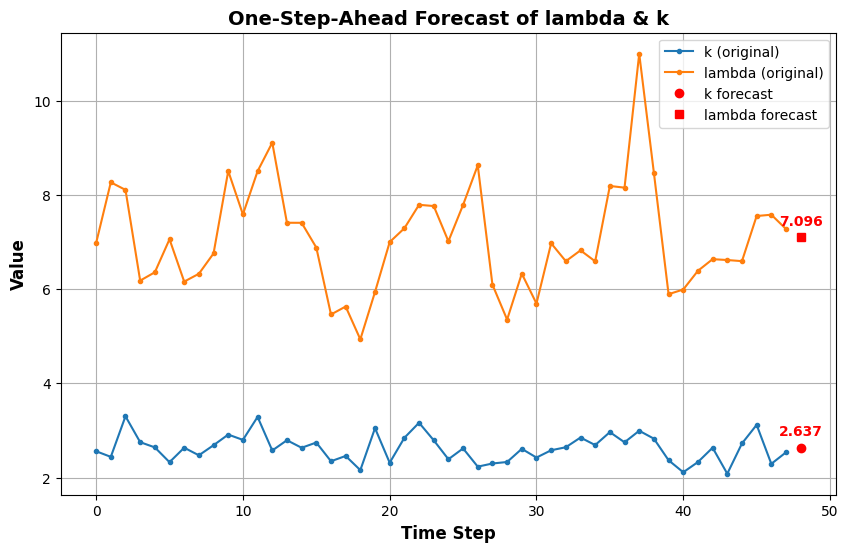

In [ ]:
# Your data
k_values_M = [2.559, 2.440, 3.301, 2.752, 2.641, 2.327, 2.634, 2.473, 2.687, 2.913, 2.800, 3.288,
              2.575, 2.793, 2.633, 2.744, 2.347, 2.459, 2.158, 3.049, 2.315, 2.844, 3.164, 2.792,
              2.389, 2.619, 2.232, 2.299, 2.331, 2.610, 2.425, 2.580, 2.644, 2.850, 2.690, 2.965,
              2.749, 2.994, 2.826, 2.368, 2.113, 2.330, 2.634, 2.082, 2.724, 3.119, 2.292, 2.536]

lambda_values_M = [6.979, 8.267, 8.107, 6.181, 6.358, 7.059, 6.160, 6.326, 6.758, 8.507, 7.586, 8.503,
                   9.109, 7.409, 7.408, 6.883, 5.462, 5.631, 4.934, 5.940, 6.999, 7.292, 7.790, 7.764,
                   7.016, 7.788, 8.628, 6.096, 5.353, 6.329, 5.694, 6.973, 6.593, 6.823, 6.590, 8.190,
                   8.154, 10.997, 8.468, 5.893, 5.992, 6.389, 6.636, 6.618, 6.594, 7.552, 7.580, 7.276]

# Create a DataFrame
Data = pd.DataFrame({
    'k': k_values_M,
    'lambda': lambda_values_M
})

# Fit VARMA model (order p=1, q=0)
model = VARMAX(Data, order=(1, 0))
model_fit = model.fit(disp=False)

# Forecast the next value
forecast = model_fit.forecast(steps=1)
print("Next predicted value:")
print(forecast)

# Prepare data for plotting
forecast_index = [len(Data)]  # Next time step
forecast_df = pd.DataFrame(forecast.values, columns=Data.columns, index=forecast_index)

# Plot the original series and forecast
plt.figure(figsize=(10, 6))
plt.plot(Data.index, Data['k'], label='k (original)', marker='.')
plt.plot(Data.index, Data['lambda'], label='lambda (original)', marker='.')
plt.plot(forecast_df.index, forecast_df['k'], 'ro', label='k forecast')
plt.plot(forecast_df.index, forecast_df['lambda'], 'rs', label='lambda forecast')

# Annotate predicted values
for col in forecast_df.columns:
    plt.text(forecast_index[0], forecast_df[col].values[0] + 0.25,
             f"{forecast_df[col].values[0]:.3f}",
             color='red', fontweight='bold', ha='center')

plt.xlabel('Time Step', fontsize=12, fontweight="bold")
plt.ylabel('Value', fontsize=12, fontweight="bold")
plt.title('One-Step-Ahead Forecast of lambda & k', fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
data

,Date and time,Wind speed (m/s),Power (kW),Month,Year
0,2017-01-01 00:00:00,7.606060,840.748535,1,2017
1,2017-01-01 00:10:00,7.813293,886.659973,1,2017
2,2017-01-01 00:20:00,7.323050,798.429199,1,2017
3,2017-01-01 00:30:00,7.559484,839.762207,1,2017
4,2017-01-01 00:40:00,7.502729,853.284729,1,2017
...,...,...,...,...,...
210379,2020-12-31 23:10:00,5.119444,253.676392,12,2020
210380,2020-12-31 23:20:00,5.009681,236.046799,12,2020
210381,2020-12-31 23:30:00,5.060813,245.340683,12,2020
210382,2020-12-31 23:40:00,4.814269,206.051880,12,2020


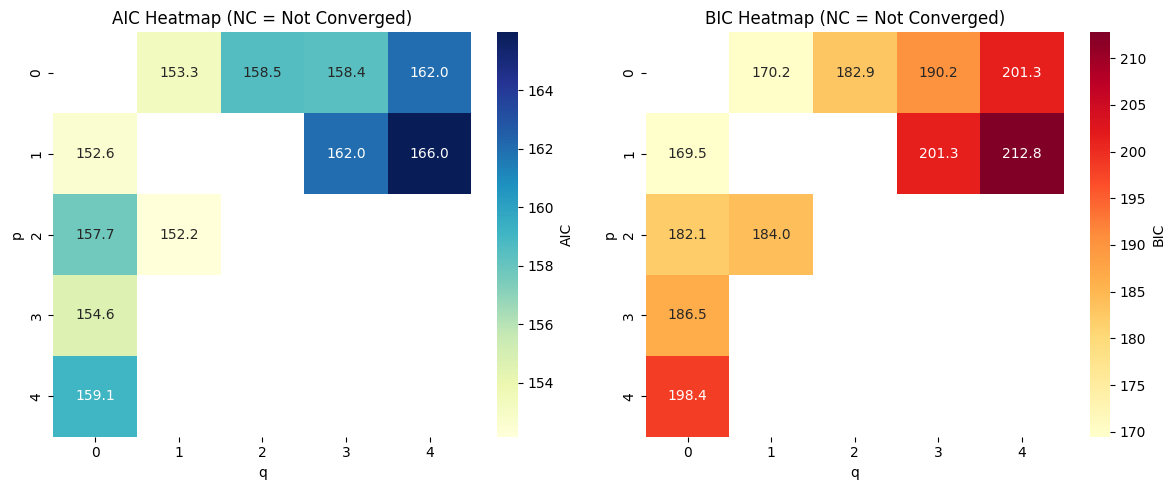

In [ ]:
#How to choose the Best p and q parameter

# Complete grid results including non-converged models
results = [
    {"p":0,"q":0,"AIC":np.nan,"BIC":np.nan,"Converged":False},
    {"p":0,"q":1,"AIC":153.310,"BIC":170.150,"Converged":True},
    {"p":0,"q":2,"AIC":158.545,"BIC":182.871,"Converged":True},
    {"p":0,"q":3,"AIC":158.387,"BIC":190.197,"Converged":True},
    {"p":0,"q":4,"AIC":161.980,"BIC":201.275,"Converged":True},
    {"p":1,"q":0,"AIC":152.643,"BIC":169.483,"Converged":True},
    {"p":1,"q":1,"AIC":157.599,"BIC":181.924,"Converged":False},
    {"p":1,"q":2,"AIC":158.965,"BIC":190.775,"Converged":False},
    {"p":1,"q":3,"AIC":162.017,"BIC":201.312,"Converged":True},
    {"p":1,"q":4,"AIC":165.971,"BIC":212.751,"Converged":True},
    {"p":2,"q":0,"AIC":157.732,"BIC":182.058,"Converged":True},
    {"p":2,"q":1,"AIC":152.161,"BIC":183.971,"Converged":True},
    {"p":2,"q":2,"AIC":156.113,"BIC":195.408,"Converged":False},
    {"p":2,"q":3,"AIC":150.537,"BIC":197.317,"Converged":False},
    {"p":2,"q":4,"AIC":151.024,"BIC":205.289,"Converged":False},
    {"p":3,"q":0,"AIC":154.648,"BIC":186.458,"Converged":True},
    {"p":3,"q":1,"AIC":150.647,"BIC":189.943,"Converged":False},
    {"p":3,"q":2,"AIC":156.762,"BIC":203.542,"Converged":False},
    {"p":3,"q":3,"AIC":161.196,"BIC":215.460,"Converged":False},
    {"p":3,"q":4,"AIC":157.387,"BIC":219.136,"Converged":False},
    {"p":4,"q":0,"AIC":159.076,"BIC":198.372,"Converged":True},
    {"p":4,"q":1,"AIC":161.758,"BIC":208.538,"Converged":False},
    {"p":4,"q":2,"AIC":159.036,"BIC":213.301,"Converged":False},
    {"p":4,"q":3,"AIC":161.057,"BIC":222.807,"Converged":False},
    {"p":4,"q":4,"AIC":161.250,"BIC":230.485,"Converged":False}
]

df = pd.DataFrame(results)

# Function to prepare heatmap matrix: show value if converged, else "NC"
def prepare_matrix(df, metric="BIC"):
    matrix = df.pivot(index="p", columns="q", values=metric)
    converged = df.pivot(index="p", columns="q", values="Converged")
    # Replace non-converged values with NaN or mark
    matrix_masked = matrix.copy()
    for i in matrix.index:
        for j in matrix.columns:
            if not converged.loc[i,j]:
                matrix_masked.loc[i,j] = np.nan  # Or "NC"
    return matrix_masked

# Prepare matrices
aic_matrix = prepare_matrix(df, "AIC")
bic_matrix = prepare_matrix(df, "BIC")

# Plot heatmaps
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(aic_matrix, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label':'AIC'})
plt.title("AIC Heatmap (NC = Not Converged)")
plt.xlabel("q")
plt.ylabel("p")

plt.subplot(1,2,2)
sns.heatmap(bic_matrix, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label':'BIC'})
plt.title("BIC Heatmap (NC = Not Converged)")
plt.xlabel("q")
plt.ylabel("p")

plt.tight_layout()
plt.show()



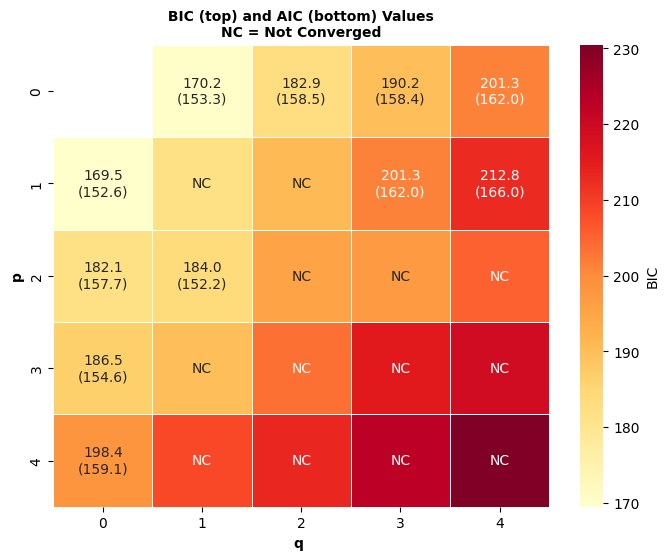

In [ ]:

# Prepare matrices
df = pd.DataFrame(results)


bic_matrix = df.pivot(index="p", columns="q", values="BIC")
converged_matrix = df.pivot(index="p", columns="q", values="Converged")


annot = []
for i in bic_matrix.index:
    row = []
    for j in bic_matrix.columns:
        if not converged_matrix.loc[i,j]:
            row.append("NC")
        else:
            b = bic_matrix.loc[i,j]
            a = df[(df['p']==i) & (df['q']==j)]['AIC'].values[0]
            row.append(f"{b:.1f}\n({a:.1f})")
    annot.append(row)

plt.figure(figsize=(8,6))
sns.heatmap(bic_matrix, annot=annot, fmt="", cmap="YlOrRd", cbar_kws={'label':'BIC'}, linewidths=0.5)
plt.title(" BIC (top) and AIC (bottom) Values \nNC = Not Converged", fontsize=10, weight='bold')
plt.xlabel("q " , fontsize=10, weight='bold')
plt.ylabel("p" , fontsize=10, weight='bold')
plt.show()


#### Model 1 -OU Analysis- Wind Speed Simulation and Power Analysis

/tmp/ipython-input-926428758.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WindT2021_Jan['Date and time'] = pd.to_datetime(WindT2021_Jan['Date and time'])


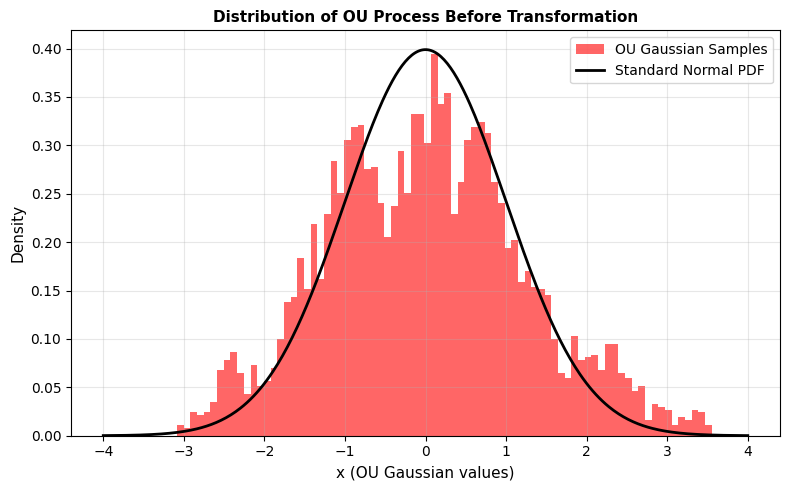

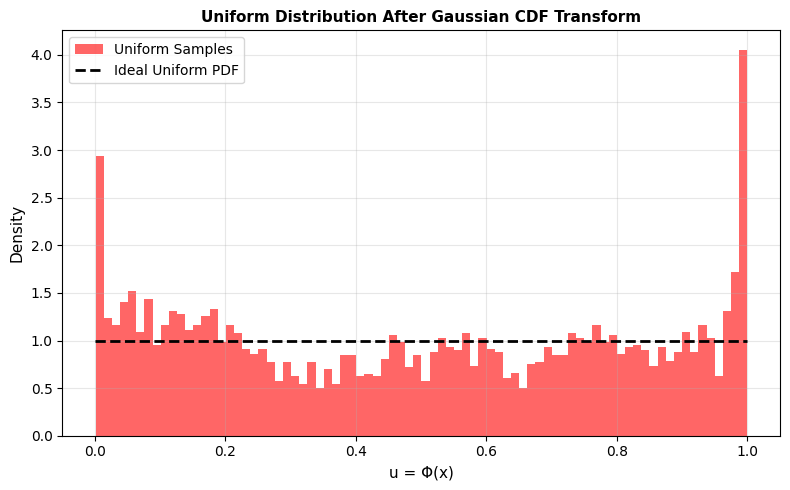

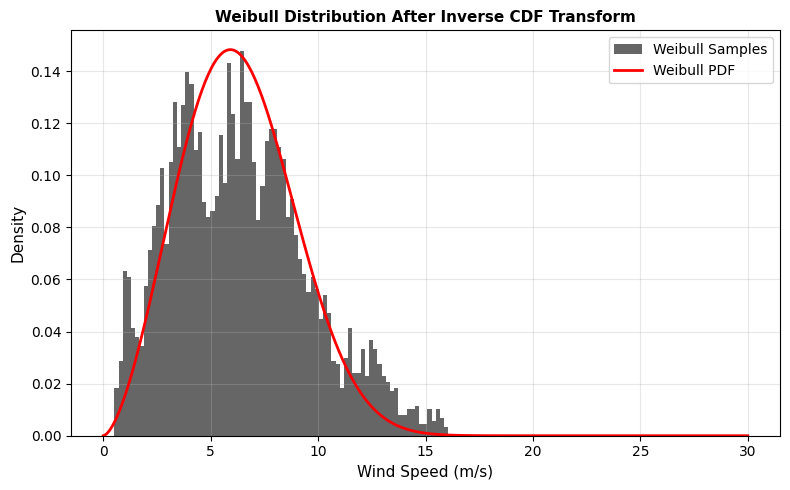

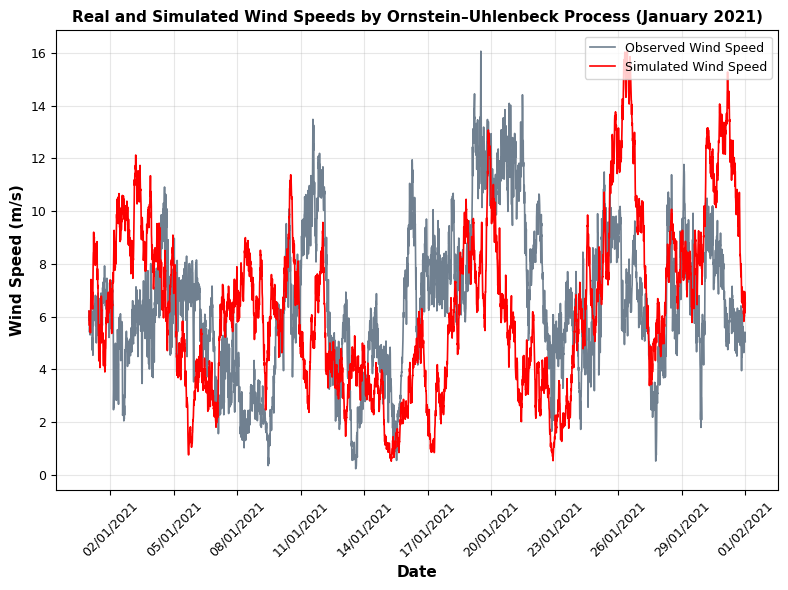

In [ ]:
from scipy.stats import norm


# =====================================================
# Weibull CDF and Inverse CDF
# =====================================================
def weibull_cdf(x, shape, scale):
    return weibull_min.cdf(x, c=shape, scale=scale)

def weibull_icdf(p, shape, scale):
    return weibull_min.ppf(p, c=shape, scale=scale)

# =====================================================
# OU–Weibull Wind Speed Model (returns x, u, y)
# =====================================================
def model_ou_weibull(dt, steps, alpha, shape, scale, start_wind_speed=5.4, seed=None):
    if seed is not None:
        np.random.seed(seed)

    x = np.zeros(steps)   # OU Gaussian process
    u = np.zeros(steps)   # Uniform(0,1)
    y = np.zeros(steps)   # Weibull wind speed

    # Initial condition
    initial_cdf = weibull_cdf(start_wind_speed, shape, scale)
    x[0] = norm.ppf(initial_cdf)
    u[0] = norm.cdf(x[0])
    y[0] = start_wind_speed

    for i in range(1, steps):
        dw = np.sqrt(dt) * np.random.normal()
        x[i] = x[i - 1] - alpha * x[i - 1] * dt + np.sqrt(2 * alpha) * dw

        u[i] = norm.cdf(x[i])                 # Gaussian → Uniform
        y[i] = weibull_icdf(u[i], shape, scale)  # Uniform → Weibull

    return x, u, y

# =====================================================
# Parameters
# =====================================================
dt = 1 / 6          # 10 minutes in hours
alpha = 0.05
k = 2.63
lam = 7.096

# =====================================================
# Observed Data
# =====================================================
WindT2021_Jan['Date and time'] = pd.to_datetime(WindT2021_Jan['Date and time'])

real = pd.Series(WindT2021_Jan['Wind speed (m/s)'].values,
                 index=WindT2021_Jan['Date and time'])

steps = len(real)

# =====================================================
# Simulation
# =====================================================
x_raw, u_raw, simulated_wind_speed = model_ou_weibull(
    dt=dt,
    steps=steps,
    alpha=alpha,
    shape=k,
    scale=lam,
    start_wind_speed=real.iloc[0],
    seed=105
)

sim1 = pd.Series(simulated_wind_speed, index=real.index)

# =====================================================
# Plot 1: OU (Gaussian) distribution — RED
# =====================================================
plt.figure(figsize=(8, 5))
plt.hist(x_raw, bins=80, density=True, alpha=0.6, color='red', label='OU Gaussian Samples')

xx = np.linspace(-4, 4, 400)
plt.plot(xx, norm.pdf(xx), 'k', lw=2, label='Standard Normal PDF')

plt.title("Distribution of OU Process Before Transformation", fontsize=11, fontweight='bold')
plt.xlabel("x (OU Gaussian values)", fontsize=11)
plt.ylabel("Density", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =====================================================
# Plot 2: Uniform distribution — BLUE
# =====================================================
plt.figure(figsize=(8, 5))
plt.hist(u_raw, bins=80, density=True, alpha=0.6, color='red', label='Uniform Samples')

plt.plot([0,1], [1,1], 'k--', lw=2, label='Ideal Uniform PDF')

plt.title("Uniform Distribution After Gaussian CDF Transform", fontsize=11, fontweight='bold')
plt.xlabel("u = Φ(x)", fontsize=11)
plt.ylabel("Density", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =====================================================
# Plot 3: Weibull distribution — BLACK
# =====================================================
plt.figure(figsize=(8, 5))
plt.hist(simulated_wind_speed, bins=80, density=True, alpha=0.6, color='black', label='Weibull Samples')

yy = np.linspace(0, 30, 400)
plt.plot(yy, weibull_min.pdf(yy, c=k, scale=lam), 'r', lw=2, label='Weibull PDF')

plt.title("Weibull Distribution After Inverse CDF Transform", fontsize=11, fontweight='bold')
plt.xlabel("Wind Speed (m/s)", fontsize=11)
plt.ylabel("Density", fontsize=11)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =====================================================
# Plot 4: Real vs Simulated Wind Speed
# =====================================================
plt.figure(figsize=(8, 6))

plt.plot(real.index, real, color='slategrey', linewidth=1.2, label='Observed Wind Speed')
plt.plot(sim1.index, sim1, color='red', linewidth=1.2, label='Simulated Wind Speed')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

plt.title(
    'Real and Simulated Wind Speeds by Ornstein–Uhlenbeck Process (January 2021)',
    fontsize=11,
    fontweight='bold'
)
plt.xlabel('Date', fontsize=11, fontweight='bold')
plt.ylabel('Wind Speed (m/s)', fontsize=11, fontweight='bold')

plt.xticks(fontsize=9, rotation=45)
plt.yticks(fontsize=9)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
data

,Date and time,Wind speed (m/s),Power (kW),Month,Year
0,2017-01-01 00:00:00,7.606060,840.748535,1,2017
1,2017-01-01 00:10:00,7.813293,886.659973,1,2017
2,2017-01-01 00:20:00,7.323050,798.429199,1,2017
3,2017-01-01 00:30:00,7.559484,839.762207,1,2017
4,2017-01-01 00:40:00,7.502729,853.284729,1,2017
...,...,...,...,...,...
210379,2020-12-31 23:10:00,5.119444,253.676392,12,2020
210380,2020-12-31 23:20:00,5.009681,236.046799,12,2020
210381,2020-12-31 23:30:00,5.060813,245.340683,12,2020
210382,2020-12-31 23:40:00,4.814269,206.051880,12,2020


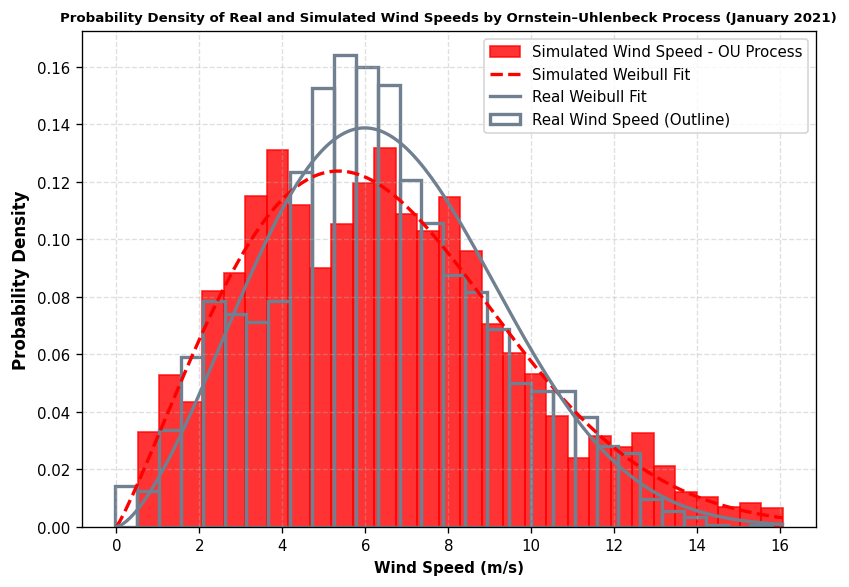


--- Simulated Wind Speed Stats ---
Min: 0.5171
Max: 16.0603
Mean: 6.3901
Std: 3.1770
Skewness: 0.4871
Kurtosis: 2.8030

--- Real Wind Speed Stats ---
Min: 0.2299
Max: 16.0589
Mean: 6.5048
Std: 2.7631
Skewness: 0.2704
Kurtosis: 2.6937


In [ ]:


# --- Fit Weibull distributions to each dataset ---
k_sim, loc_sim, lam_sim = weibull_min.fit(sim1, floc=0)
k_real, loc_real, lam_real = weibull_min.fit(real, floc=0)

# --- Plot Histogram and PDFs ---
plt.figure(figsize=(7, 5), dpi=120)

# Histogram: Simulated Wind (filled)
plt.hist(sim1, bins=30, density=True, alpha=0.8,
         color='red', edgecolor='red', label='Simulated Wind Speed - OU Process')

# Histogram: Real Wind Speed (outline only)
counts, bins = np.histogram(real, bins=30, density=True)
bin_width = bins[1] - bins[0]

plt.bar(
    bins[:-1],
    counts,
    width=bin_width,
    edgecolor='slategrey',
    linewidth=2.0,
    fill=False,
    label='Real Wind Speed (Outline)'
)

# Weibull PDF: Simulated
x_sim = np.linspace(0, sim1.max(), 200)
pdf_sim = weibull_min.pdf(x_sim, c=k_sim, scale=lam_sim)
plt.plot(x_sim, pdf_sim, color='red', lw=2,
         label='Simulated Weibull Fit', linestyle='--')

# Weibull PDF: Real
x_real = np.linspace(0, real.max(), 200)
pdf_real = weibull_min.pdf(x_real, c=k_real, scale=lam_real)
plt.plot(x_real, pdf_real, color='slategrey', lw=2,
         label='Real Weibull Fit')

# ---- Styling (BOLD TITLES) ----
plt.title(
    "Probability Density of Real and Simulated Wind Speeds by Ornstein–Uhlenbeck Process (January 2021)",
    fontsize=8,
    fontweight='bold'
)
plt.xlabel("Wind Speed (m/s)", fontsize=9, fontweight='bold')
plt.ylabel("Probability Density", fontsize=10, fontweight='bold')

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

# --- Compute Statistical Parameters from Histograms ---

def histogram_stats(data, bins=30):
    counts, edges = np.histogram(data, bins=bins, density=True)
    midpoints = 0.5 * (edges[1:] + edges[:-1])
    prob_density = counts / np.sum(counts)

    mean = np.sum(midpoints * prob_density)
    std = np.sqrt(np.sum(((midpoints - mean) ** 2) * prob_density))
    skewness = np.sum(((midpoints - mean) ** 3) * prob_density) / std**3
    kurt = np.sum(((midpoints - mean) ** 4) * prob_density) / std**4

    return {
        "Min": data.min(),
        "Max": data.max(),
        "Mean": mean,
        "Std": std,
        "Skewness": skewness,
        "Kurtosis": kurt
    }

# Compute and print results
sim_stats = histogram_stats(sim1)
real_stats = histogram_stats(real)

print("\n--- Simulated Wind Speed Stats ---")
for k, v in sim_stats.items():
    print(f"{k}: {v:.4f}")

print("\n--- Real Wind Speed Stats ---")
for k, v in real_stats.items():
    print(f"{k}: {v:.4f}")


In [ ]:
# -----------------------------------------------------
# Histogram parameters
# -----------------------------------------------------
bins = 30   # choose same number of bins for both
hist_range = (0, max(real.max(), sim1.max()))

# -----------------------------------------------------
# Real histogram
# -----------------------------------------------------
real_hist, bin_edges = np.histogram(real, bins=bins, range=hist_range, density=True)

# -----------------------------------------------------
# Simulated histogram
# -----------------------------------------------------
sim_hist, _ = np.histogram(sim1, bins=bins, range=hist_range, density=True)



# -----------------------------------------------------
# Metrics between histogram bin heights
# -----------------------------------------------------
MAE_hist = mean_absolute_error(real_hist, sim_hist)
RMSE_hist = np.sqrt(mean_squared_error(real_hist, sim_hist))
R2_hist = r2_score(real_hist, sim_hist)

print("Histogram Comparison Metrics:")
print(f"MAE  = {MAE_hist:.6f}")
print(f"RMSE = {RMSE_hist:.6f}")
print(f"R²   = {R2_hist:.6f}")




Histogram Comparison Metrics:
MAE  = 0.017324
RMSE = 0.024832
R²   = 0.764181


- Wind Power Prediction

In [ ]:
# === Create date range for 10-minute intervals starting from Jan 1, 2021 ===
date_range = pd.date_range(start='2021-01-01 00:00:00', periods=len(simulated_wind_speed), freq='10T')

# === Create the DataFrame ===
df_simulated_OU = pd.DataFrame({
    'Date and time': date_range,
    'Wind speed (m/s)':simulated_wind_speed
})

# === Optional: Display first few rows ===



/tmp/ipython-input-3476573992.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start='2021-01-01 00:00:00', periods=len(simulated_wind_speed), freq='10T')


In [ ]:
df_simulated_OU

,Date and time,Wind speed (m/s)
0,2021-01-01 00:00:00,6.204656
1,2021-01-01 00:10:00,6.118853
2,2021-01-01 00:20:00,5.906488
3,2021-01-01 00:30:00,5.658608
4,2021-01-01 00:40:00,5.683195
...,...,...
4459,2021-01-31 23:10:00,6.946906
4460,2021-01-31 23:20:00,6.848206
4461,2021-01-31 23:30:00,6.624670
4462,2021-01-31 23:40:00,6.143123


In [ ]:

# Wind Power Estimator - Training the Model

# Extracting the relevant features (Wind Speed) and target (Power)
X = data[['Wind speed (m/s)']]  # Features (Wind speed)
y = data['Power (kW)']         # Target (Power)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBRegressor
model = xgb.XGBRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

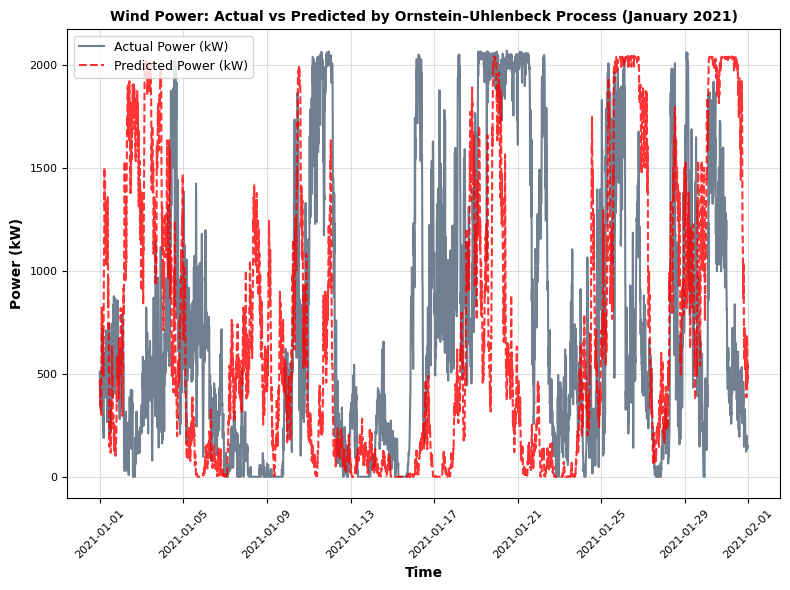

In [ ]:
# Power Prediction
# --- Prepare Data ---
X1 = df_simulated_OU[['Wind speed (m/s)']]
y1 = WindT2021_Jan['Power (kW)']
y_pred1 = model.predict(X1)

# Create result DataFrame
result_df_ou = df_simulated_OU[['Date and time']].copy()
result_df_ou['Actual Power (kW)'] = y1
result_df_ou['Predicted Power (kW)'] = y_pred1

# --- Plot ---
plt.figure(figsize=(8, 6), dpi=100)

# Plot actual and predicted with transparency
plt.plot(result_df_ou['Date and time'], result_df_ou['Actual Power (kW)'],
         label='Actual Power (kW)', color='slategrey', alpha=1, linewidth=1.5)

plt.plot(result_df_ou['Date and time'], result_df_ou['Predicted Power (kW)'],
         label='Predicted Power (kW)', color='red', linestyle='--', alpha=0.8, linewidth=1.5)

# Titles and labels
plt.title('Wind Power: Actual vs Predicted by Ornstein–Uhlenbeck Process (January 2021)', fontsize=10, fontweight='bold')
plt.xlabel('Time', fontsize=10, fontweight='bold')
plt.ylabel('Power (kW)', fontsize=10, fontweight='bold')

# Legend, grid, ticks
plt.legend(fontsize=9)
plt.grid(True, alpha=0.4)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)

# Layout
plt.tight_layout()
plt.show()


In [ ]:
# Area under the curves (kWh)
dt_hours = 10 / 60
area_actual = np.trapz(result_df_ou['Actual Power (kW)'], dx=dt_hours)
area_predicted = np.trapz(result_df_ou['Predicted Power (kW)'], dx=dt_hours)

print(f"Total Actual Energy: {area_actual:.2f} kWh")
print(f"Total Predicted Energy: {area_predicted:.2f} kWh")

Total Actual Energy: 560225.40 kWh
Total Predicted Energy: 522344.91 kWh


/tmp/ipython-input-1394635574.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_actual = np.trapz(result_df_ou['Actual Power (kW)'], dx=dt_hours)
/tmp/ipython-input-1394635574.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_predicted = np.trapz(result_df_ou['Predicted Power (kW)'], dx=dt_hours)


### Model 2 - Fokker Planck - Drift Based


/tmp/ipython-input-318886447.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WindT2021_Jan['Date and time'] = pd.to_datetime(WindT2021_Jan['Date and time'])


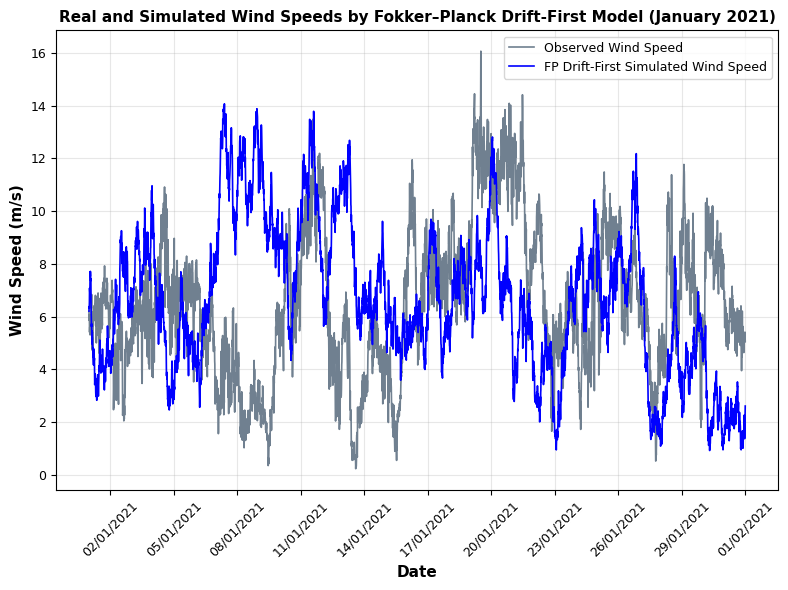

In [ ]:
## Model 2- Wind Speed Simulation Through Fokker Plnack -Drift Based

# =====================================================
# Weibull PDF
# =====================================================
def weibull_pdf(x, shape, scale):
    return weibull_min.pdf(x, c=shape, scale=scale)

# =====================================================
# Mean of the Weibull distribution
# =====================================================
def weibull_mean(shape, scale):
    return scale * gamma(1 + 1 / shape)

# =====================================================
# Incomplete upper gamma function Γ(s, x)
# =====================================================
def incomplete_upper_gamma(s, x):
    return gamma(s) * (1 - gammainc(s, x))

# =====================================================
# Diffusion term
# =====================================================
def diffusion_term(x, alpha, shape, scale, mu_w):
    pw = weibull_pdf(x, shape, scale)

    # Avoid division by zero
    if pw <= 1e-12:
        return 0.0

    x_scaled = (x / scale) ** shape
    gamma_incomplete = scale * incomplete_upper_gamma(1 + 1 / shape, x_scaled)
    term = gamma_incomplete - mu_w * np.exp(-x_scaled)

    b_squared = (2 * alpha / pw) * term
    b_squared = np.maximum(b_squared, 0)  # ensure non-negativity

    return np.sqrt(b_squared)

# =====================================================
# Model 2: Fokker–Planck SDE (Drift-First)
# =====================================================
def model_2(dt, steps, alpha, shape, scale, start_wind_speed=5.4, seed=None):
    if seed is not None:
        np.random.seed(seed)

    x = np.zeros(steps)
    x[0] = start_wind_speed

    mu_w = weibull_mean(shape, scale)

    for i in range(1, steps):
        drift = -alpha * (x[i - 1] - mu_w)
        diffusion = diffusion_term(x[i - 1], alpha, shape, scale, mu_w)
        dw = np.sqrt(dt) * np.random.normal()

        x[i] = x[i - 1] + drift * dt + diffusion * dw

        # Physical constraint
        if x[i] < 0:
            x[i] = 0.0

    return x

# =====================================================
# Parameters
# =====================================================
dt = 1 / 6          # 10 minutes in hours
alpha = 0.05
k = 2.63
lam = 7.096

# =====================================================
# Observed Data
# =====================================================
WindT2021_Jan['Date and time'] = pd.to_datetime(WindT2021_Jan['Date and time'])

real = pd.Series(
    WindT2021_Jan['Wind speed (m/s)'].values,
    index=WindT2021_Jan['Date and time']
)

steps = len(real)

# =====================================================
# Simulation (Model 2)
# =====================================================
simulated_model2 = model_2(
    dt=dt,
    steps=steps,
    alpha=alpha,
    shape=k,
    scale=lam,
    start_wind_speed=real.iloc[0],
    seed=42
)

sim2 = pd.Series(simulated_model2, index=real.index)

# =====================================================
# (Optional) Smoothing
# =====================================================
real_smooth = real.rolling(window=1, center=True).mean()
sim_smoothFPD = sim2.rolling(window=1, center=True).mean()

# =====================================================
# Plot — MATCHED VISUALIZATION STYLE
# =====================================================
plt.figure(figsize=(8, 6))

plt.plot(
    real_smooth.index,
    real_smooth,
    color='slategrey',
    linewidth=1.2,
    label='Observed Wind Speed'
)

plt.plot(
    sim_smoothFPD.index,
    sim_smoothFPD,
    color='blue',
    linewidth=1.2,
    label='FP Drift-First Simulated Wind Speed'
)

# ---- Date formatting ----
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

plt.title(
    'Real and Simulated Wind Speeds by Fokker–Planck Drift-First Model (January 2021)',
    fontsize=11,
    fontweight='bold'
)

plt.xlabel('Date', fontsize=11, fontweight='bold')
plt.ylabel('Wind Speed (m/s)', fontsize=11, fontweight='bold')

plt.xticks(fontsize=9, rotation=45)
plt.yticks(fontsize=9)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, loc='upper right')

plt.tight_layout()
plt.show()


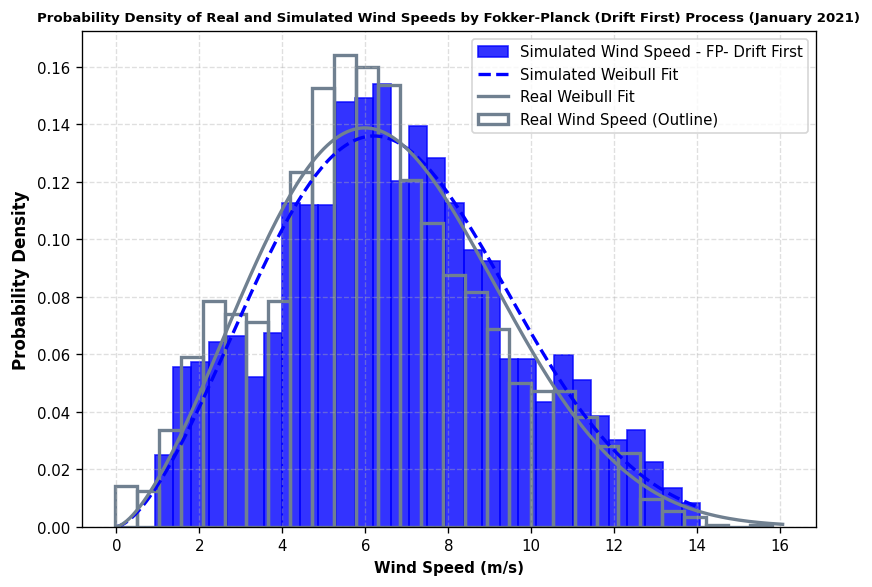


--- Simulated Wind Speed Stats ---
Min: 0.9212
Max: 14.0630
Mean: 6.6947
Std: 2.8342
Skewness: 0.2260
Kurtosis: 2.5405

--- Real Wind Speed Stats ---
Min: 0.2299
Max: 16.0589
Mean: 6.5048
Std: 2.7631
Skewness: 0.2704
Kurtosis: 2.6937


In [ ]:
## Weibull Fit in Wind Speed Simulation and Real Wind Speed

k_sim, loc_sim, lam_sim = weibull_min.fit(sim2, floc=0)
k_real, loc_real, lam_real = weibull_min.fit(real, floc=0)


plt.figure(figsize=(7, 5), dpi=120)


plt.hist(sim2, bins=30, density=True, alpha=0.8,
         color='blue', edgecolor='blue', label='Simulated Wind Speed - FP- Drift First')


counts, bins = np.histogram(real, bins=30, density=True)
bin_width = bins[1] - bins[0]

plt.bar(
    bins[:-1],
    counts,
    width=bin_width,
    edgecolor='slategrey',
    linewidth=2.0,
    fill=False,
    label='Real Wind Speed (Outline)'
)

# Weibull PDF: Simulated
x_sim = np.linspace(0, sim2.max(), 200)
pdf_sim = weibull_min.pdf(x_sim, c=k_sim, scale=lam_sim)
plt.plot(x_sim, pdf_sim, color='blue', lw=2,
         label='Simulated Weibull Fit', linestyle='--')


x_real = np.linspace(0, real_smooth.max(), 200)
pdf_real = weibull_min.pdf(x_real, c=k_real, scale=lam_real)
plt.plot(x_real, pdf_real, color='slategrey', lw=2,
         label='Real Weibull Fit')


plt.title(
    "Probability Density of Real and Simulated Wind Speeds by Fokker-Planck (Drift First) Process (January 2021)",
    fontsize=8,
    fontweight='bold'
)
plt.xlabel("Wind Speed (m/s)", fontsize=9, fontweight='bold')
plt.ylabel("Probability Density", fontsize=10, fontweight='bold')

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=9, frameon=True)
plt.tight_layout()
plt.show()



def histogram_stats(data, bins=30):
    counts, edges = np.histogram(data, bins=bins, density=True)
    midpoints = 0.5 * (edges[1:] + edges[:-1])
    prob_density = counts / np.sum(counts)

    mean = np.sum(midpoints * prob_density)
    std = np.sqrt(np.sum(((midpoints - mean) ** 2) * prob_density))
    skewness = np.sum(((midpoints - mean) ** 3) * prob_density) / std**3
    kurt = np.sum(((midpoints - mean) ** 4) * prob_density) / std**4

    return {
        "Min": data.min(),
        "Max": data.max(),
        "Mean": mean,
        "Std": std,
        "Skewness": skewness,
        "Kurtosis": kurt
    }


sim_stats = histogram_stats(sim2)
real_stats = histogram_stats(real)

print("\n--- Simulated Wind Speed Stats ---")
for k, v in sim_stats.items():
    print(f"{k}: {v:.4f}")

print("\n--- Real Wind Speed Stats ---")
for k, v in real_stats.items():
    print(f"{k}: {v:.4f}")

In [ ]:
# === Create date range for 10-minute intervals starting from Jan 1, 2021 ===
date_range = pd.date_range(start='2021-01-01 00:00:00', periods=len(sim2), freq='10T')


df_simulated_FKP = pd.DataFrame({
    'Date and time': date_range,
    'Wind speed (m/s)':sim2
})


/tmp/ipython-input-1350077286.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start='2021-01-01 00:00:00', periods=len(sim2), freq='10T')


In [ ]:

result_df_ou

,Date and time,Actual Power (kW),Predicted Power (kW)
0,2021-01-01 00:00:00,510.487854,470.885742
1,2021-01-01 00:10:00,421.761902,450.046722
2,2021-01-01 00:20:00,486.600555,403.096405
3,2021-01-01 00:30:00,450.720245,351.580170
4,2021-01-01 00:40:00,341.076813,358.503510
...,...,...,...
4459,2021-01-31 23:10:00,146.059116,685.917114
4460,2021-01-31 23:20:00,135.678171,654.924133
4461,2021-01-31 23:30:00,155.834991,581.569031
4462,2021-01-31 23:40:00,140.325806,456.749786


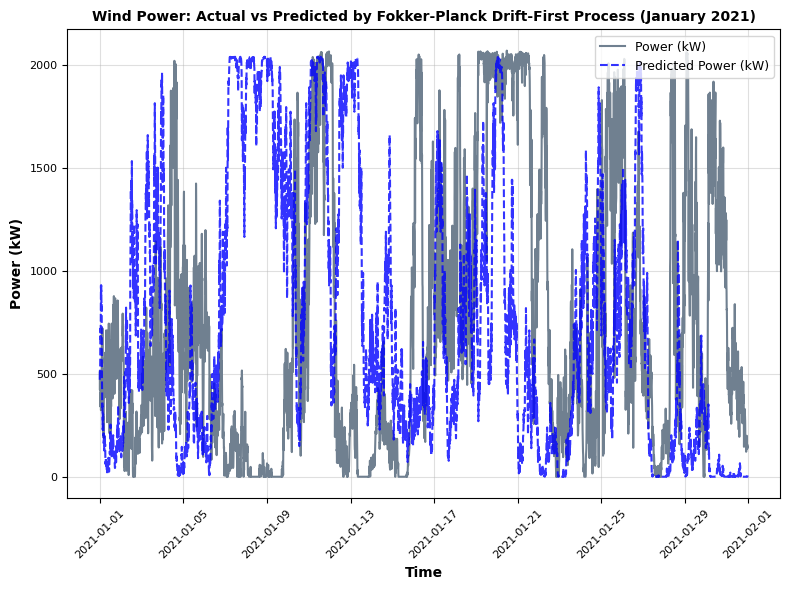

In [ ]:
# --- Prepare Data ---
X1 = df_simulated_FKP[['Wind speed (m/s)']]


y1 = WindT2021_Jan['Power (kW)'].values


y_pred1 = model.predict(X1)


result_df_fkp = df_simulated_FKP[['Date and time']].copy()
result_df_fkp['Power (kW)'] = y1
result_df_fkp['Predicted Power (kW)'] = y_pred1



plt.figure(figsize=(8, 6), dpi=100)


plt.plot(result_df_fkp['Date and time'], result_df_fkp['Power (kW)'],
         label='Power (kW)', color='slategrey', alpha=1, linewidth=1.5)

plt.plot(result_df_fkp['Date and time'], result_df_fkp['Predicted Power (kW)'],
         label='Predicted Power (kW)', color='blue', linestyle='--', alpha=0.8, linewidth=1.5)


plt.title('Wind Power: Actual vs Predicted by Fokker-Planck Drift-First Process (January 2021)', fontsize=10, fontweight='bold')
plt.xlabel('Time', fontsize=10, fontweight='bold')
plt.ylabel('Power (kW)', fontsize=10, fontweight='bold')


plt.legend(fontsize=9)
plt.grid(True, alpha=0.4)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)


plt.tight_layout()
plt.show()

In [ ]:
result_df_fkp=result_df_fkp.reset_index(drop=True)
result_df_fkp

,Date and time,Power (kW),Predicted Power (kW)
0,2021-01-01 00:00:00,510.487854,470.885742
1,2021-01-01 00:10:00,421.761902,520.524841
2,2021-01-01 00:20:00,486.600555,499.414276
3,2021-01-01 00:30:00,450.720245,563.307800
4,2021-01-01 00:40:00,341.076813,719.066345
...,...,...,...
4459,2021-01-31 23:10:00,146.059116,0.004231
4460,2021-01-31 23:20:00,135.678171,0.016173
4461,2021-01-31 23:30:00,155.834991,0.200174
4462,2021-01-31 23:40:00,140.325806,1.760252


In [ ]:
df_simulated_FKP=df_simulated_FKP.reset_index(drop=True)
df_simulated_FKP

,Date and time,Wind speed (m/s)
0,2021-01-01 00:00:00,6.204656
1,2021-01-01 00:10:00,6.375953
2,2021-01-01 00:20:00,6.327719
3,2021-01-01 00:30:00,6.550459
4,2021-01-01 00:40:00,7.075230
...,...,...
4459,2021-01-31 23:10:00,1.369322
4460,2021-01-31 23:20:00,1.553089
4461,2021-01-31 23:30:00,1.862338
4462,2021-01-31 23:40:00,2.350089


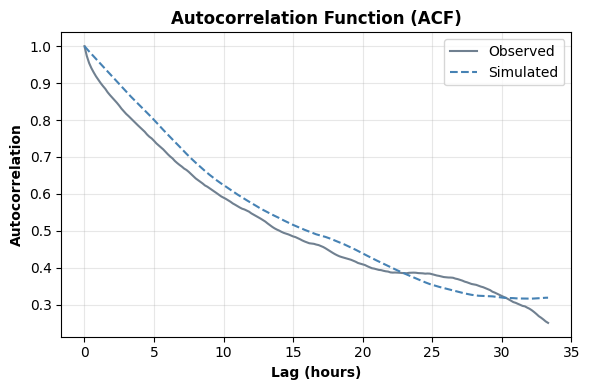

In [ ]:

max_lag = 200  # ~33 hours for 10-min data

acf_real = acf(real.values, nlags=max_lag, fft=True)
acf_sim  = acf(sim2.values,  nlags=max_lag, fft=True)

lags = np.arange(len(acf_real)) * dt  # hours

plt.figure(figsize=(6,4))
plt.plot(lags, acf_real, label='Observed', color='slategrey')
plt.plot(lags, acf_sim, label='Simulated', color='steelblue', linestyle='--')

plt.xlabel('Lag (hours)', fontweight='bold')
plt.ylabel('Autocorrelation', fontweight='bold')
plt.title('Autocorrelation Function (ACF)', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:



# Area under the curves (kWh)
dt_hours = 10 / 60
area_actual = np.trapz(result_df_fkp['Power (kW)'], dx=dt_hours)
area_predicted = np.trapz(result_df_fkp['Predicted Power (kW)'], dx=dt_hours)

print(f"Total Actual Energy: {area_actual:.2f} kWh")
print(f"Total Predicted Energy: {area_predicted:.2f} kWh")

Total Actual Energy: 560225.40 kWh
Total Predicted Energy: 567330.00 kWh


/tmp/ipython-input-4041486959.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_actual = np.trapz(result_df_fkp['Power (kW)'], dx=dt_hours)
/tmp/ipython-input-4041486959.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_predicted = np.trapz(result_df_fkp['Predicted Power (kW)'], dx=dt_hours)


### Model 3 - Fokker Plank - Diffusion Based

In [ ]:
#Model 3- Fokker Plank- Diffusion First

def sigma_weibull_squared(k, lam):
    """Compute the variance of the Weibull distribution."""
    mean = lam * gamma(1 + 1/k)
    second_moment = lam**2 * gamma(1 + 2/k)
    return second_moment - mean**2

def drift_model_3(x, alpha, k, lam):
    """Compute drift a(x) to ensure Weibull stationary distribution."""
    sigma_w2 = sigma_weibull_squared(k, lam)
    # Avoid division by zero
    if x <= 0:
        return 0.0
    term1 = (k - 1) / k
    term2 = (x / lam)**k
    return alpha * sigma_w2 * (k / x) * (term1 - term2)

def diffusion_model_3(alpha, k, lam):
    """Constant diffusion term b(x) = sqrt(2 * alpha * sigma_W^2)."""
    sigma_w2 = sigma_weibull_squared(k, lam)
    return np.sqrt(2 * alpha * sigma_w2)

def model_3(dt, steps, alpha, k, lam, seed=None):
    if seed is not None:
        np.random.seed(seed)

    x = np.zeros(steps)
    mu_w = lam * gamma(1 + 1/k)  # Start at the mean of Weibull
    x[0] = mu_w
    b_const = diffusion_model_3(alpha, k, lam)

    for i in range(steps - 1):
        a_val = drift_model_3(x[i], alpha, k, lam)
        dw = np.sqrt(dt) * np.random.normal()
        x_next = x[i] + a_val * dt + b_const * dw
        x[i + 1] = max(x_next, 0.0)  # Ensure wind speed stays positive

    return x

/tmp/ipython-input-2988776186.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WindT2021_Jan['Date and time'] = pd.to_datetime(WindT2021_Jan['Date and time'])


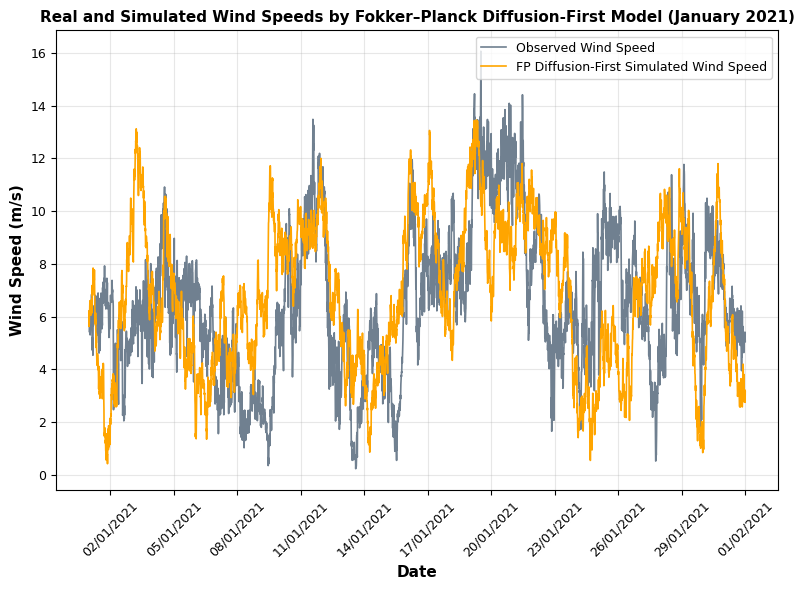

In [ ]:


# =====================================================
# Weibull variance
# =====================================================
def sigma_weibull_squared(k, lam):
    mean = lam * gamma(1 + 1 / k)
    second_moment = lam**2 * gamma(1 + 2 / k)
    return second_moment - mean**2

# =====================================================
# Drift term (Diffusion-first formulation)
# =====================================================
def drift_model_3(x, alpha, k, lam):
    sigma_w2 = sigma_weibull_squared(k, lam)

    if x <= 0:
        return 0.0

    term1 = (k - 1) / k
    term2 = (x / lam) ** k
    return alpha * sigma_w2 * (k / x) * (term1 - term2)

# =====================================================
# Constant diffusion
# =====================================================
def diffusion_model_3(alpha, k, lam):
    sigma_w2 = sigma_weibull_squared(k, lam)
    return np.sqrt(2 * alpha * sigma_w2)

# =====================================================
# Model 3: Fokker–Planck SDE (Diffusion-First)
# =====================================================
def model_3(dt, steps, alpha, k, lam, start_wind_speed, seed=None):
    if seed is not None:
        np.random.seed(seed)

    x = np.zeros(steps)
    x[0] = start_wind_speed

    b_const = diffusion_model_3(alpha, k, lam)

    for i in range(steps - 1):
        drift = drift_model_3(x[i], alpha, k, lam)
        dw = np.sqrt(dt) * np.random.normal()
        x_next = x[i] + drift * dt + b_const * dw
        x[i + 1] = max(x_next, 0.0)

    return x

# =====================================================
# Parameters
# =====================================================
dt = 1 / 6
alpha = 0.05
k = 2.63
lam = 7.096

# =====================================================
# Observed Data
# =====================================================
WindT2021_Jan['Date and time'] = pd.to_datetime(WindT2021_Jan['Date and time'])

real = pd.Series(
    WindT2021_Jan['Wind speed (m/s)'].values,
    index=WindT2021_Jan['Date and time']
)

steps = len(real)

# =====================================================
# Simulation (Model 3)
# =====================================================
simulated_model3 = model_3(
    dt=dt,
    steps=steps,
    alpha=alpha,
    k=k,
    lam=lam,
    start_wind_speed=real.iloc[0],
    seed=100
)

sim3 = pd.Series(simulated_model3, index=real.index)

# =====================================================
# (Optional) Smoothing
# =====================================================
real_smooth = real.rolling(window=1, center=True).mean()
sim_smoothFPDiff = sim3.rolling(window=1, center=True).mean()

# =====================================================
# Plot — MATCHED VISUALIZATION STYLE
# =====================================================
plt.figure(figsize=(8, 6))

plt.plot(
    real_smooth.index,
    real_smooth,
    color='slategrey',
    linewidth=1.2,
    label='Observed Wind Speed'
)

plt.plot(
    sim_smoothFPDiff.index,
    sim_smoothFPDiff,
    color='orange',
    linewidth=1.2,
    label='FP Diffusion-First Simulated Wind Speed'
)

# ---- Date formatting ----
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

plt.title(
    'Real and Simulated Wind Speeds by Fokker–Planck Diffusion-First Model (January 2021)',
    fontsize=11,
    fontweight='bold'
)

plt.xlabel('Date', fontsize=11, fontweight='bold')
plt.ylabel('Wind Speed (m/s)', fontsize=11, fontweight='bold')

plt.xticks(fontsize=9, rotation=45)
plt.yticks(fontsize=9)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, loc='upper right')

plt.tight_layout()
plt.show()



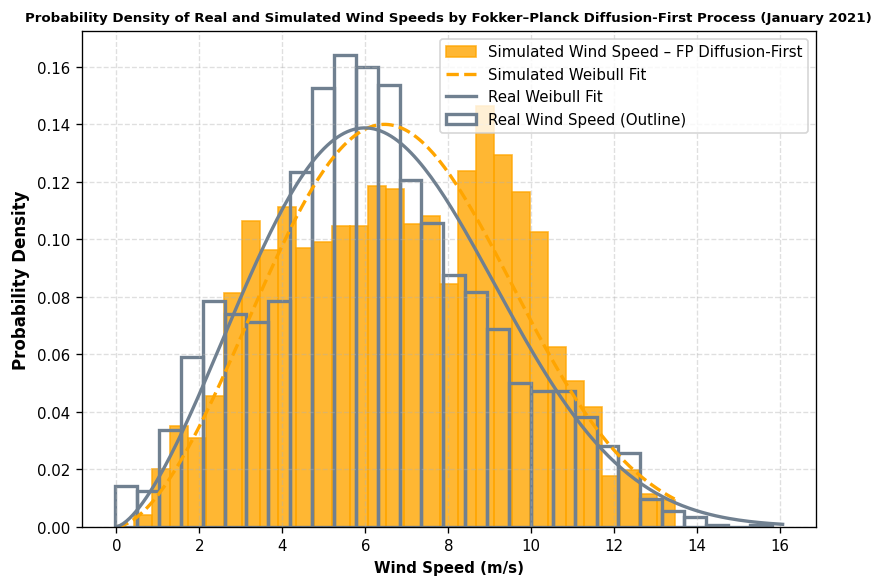


--- Simulated Wind Speed Stats (FP Diffusion-First) ---
Min: 0.4206
Max: 13.4535
Mean: 6.8184
Std: 2.7795
Skewness: -0.0375
Kurtosis: 2.1142

--- Real Wind Speed Stats ---
Min: 0.2299
Max: 16.0589
Mean: 6.5048
Std: 2.7631
Skewness: 0.2704
Kurtosis: 2.6937


In [ ]:


# =====================================================
# Fit Weibull distributions
# =====================================================
k_sim, loc_sim, lam_sim = weibull_min.fit(simulated_model3, floc=0)
k_real, loc_real, lam_real = weibull_min.fit(real, floc=0)

# =====================================================
# Plot Histogram and PDFs — MATCHED STYLE
# =====================================================
plt.figure(figsize=(7, 5), dpi=120)

# Histogram: Simulated Wind (filled)
plt.hist(
    simulated_model3,
    bins=30,
    density=True,
    alpha=0.8,
    color='orange',
    edgecolor='orange',
    label='Simulated Wind Speed – FP Diffusion-First'
)

# Histogram: Real Wind Speed (outline only)
counts, bins = np.histogram(real, bins=30, density=True)
bin_width = bins[1] - bins[0]

plt.bar(
    bins[:-1],
    counts,
    width=bin_width,
    edgecolor='slategrey',
    linewidth=2.0,
    fill=False,
    label='Real Wind Speed (Outline)'
)

# Weibull PDF: Simulated
x_sim = np.linspace(0, simulated_model3.max(), 200)
pdf_sim = weibull_min.pdf(x_sim, c=k_sim, scale=lam_sim)
plt.plot(
    x_sim,
    pdf_sim,
    color='orange',
    lw=2,
    linestyle='--',
    label='Simulated Weibull Fit'
)

# Weibull PDF: Real
x_real = np.linspace(0, real.max(), 200)
pdf_real = weibull_min.pdf(x_real, c=k_real, scale=lam_real)
plt.plot(
    x_real,
    pdf_real,
    color='slategrey',
    lw=2,
    label='Real Weibull Fit'
)

# =====================================================
# Styling — MATCHED TO DRIFT-FIRST FIGURE
# =====================================================
plt.title(
    "Probability Density of Real and Simulated Wind Speeds by "
    "Fokker–Planck Diffusion-First Process (January 2021)",
    fontsize=8,
    fontweight='bold'
)

plt.xlabel("Wind Speed (m/s)", fontsize=9, fontweight='bold')
plt.ylabel("Probability Density", fontsize=10, fontweight='bold')

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=9, frameon=True)

plt.tight_layout()
plt.show()

# =====================================================
# Histogram-based statistics
# =====================================================
def histogram_stats(data, bins=30):
    counts, edges = np.histogram(data, bins=bins, density=True)
    midpoints = 0.5 * (edges[1:] + edges[:-1])
    prob_density = counts / np.sum(counts)

    mean = np.sum(midpoints * prob_density)
    std = np.sqrt(np.sum(((midpoints - mean) ** 2) * prob_density))
    skewness = np.sum(((midpoints - mean) ** 3) * prob_density) / std**3
    kurt = np.sum(((midpoints - mean) ** 4) * prob_density) / std**4

    return {
        "Min": data.min(),
        "Max": data.max(),
        "Mean": mean,
        "Std": std,
        "Skewness": skewness,
        "Kurtosis": kurt
    }

# =====================================================
# Compute and print statistics
# =====================================================
sim_stats = histogram_stats(simulated_model3)
real_stats = histogram_stats(real)

print("\n--- Simulated Wind Speed Stats (FP Diffusion-First) ---")
for k, v in sim_stats.items():
    print(f"{k}: {v:.4f}")

print("\n--- Real Wind Speed Stats ---")
for k, v in real_stats.items():
    print(f"{k}: {v:.4f}")



In [ ]:
# === Create date range for 10-minute intervals starting from Jan 1, 2021 ===
date_range = pd.date_range(start='2021-01-01 00:00:00', periods=len(simulated_model3), freq='10T')


df_simulated_FPDI = pd.DataFrame({
    'Date and time': date_range,
    'Wind speed (m/s)':simulated_model3
})



/tmp/ipython-input-2379793916.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(start='2021-01-01 00:00:00', periods=len(simulated_model3), freq='10T')


In [ ]:
df_simulated_FPDI

,Date and time,Wind speed (m/s)
0,2021-01-01 00:00:00,6.204656
1,2021-01-01 00:10:00,5.620305
2,2021-01-01 00:20:00,5.736391
3,2021-01-01 00:30:00,6.121403
4,2021-01-01 00:40:00,6.035993
...,...,...
4459,2021-01-31 23:10:00,2.771307
4460,2021-01-31 23:20:00,3.219669
4461,2021-01-31 23:30:00,3.184286
4462,2021-01-31 23:40:00,2.747238


In [ ]:
data

,Date and time,Wind speed (m/s),Power (kW),Month,Year
0,2017-01-01 00:00:00,7.606060,840.748535,1,2017
1,2017-01-01 00:10:00,7.813293,886.659973,1,2017
2,2017-01-01 00:20:00,7.323050,798.429199,1,2017
3,2017-01-01 00:30:00,7.559484,839.762207,1,2017
4,2017-01-01 00:40:00,7.502729,853.284729,1,2017
...,...,...,...,...,...
210379,2020-12-31 23:10:00,5.119444,253.676392,12,2020
210380,2020-12-31 23:20:00,5.009681,236.046799,12,2020
210381,2020-12-31 23:30:00,5.060813,245.340683,12,2020
210382,2020-12-31 23:40:00,4.814269,206.051880,12,2020


In [ ]:

#Training Machine Learning Model

X = data[['Wind speed (m/s)']]  # Features (Wind speed)
y = data['Power (kW)']         # Target (Power)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=100, random_state=42)


model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

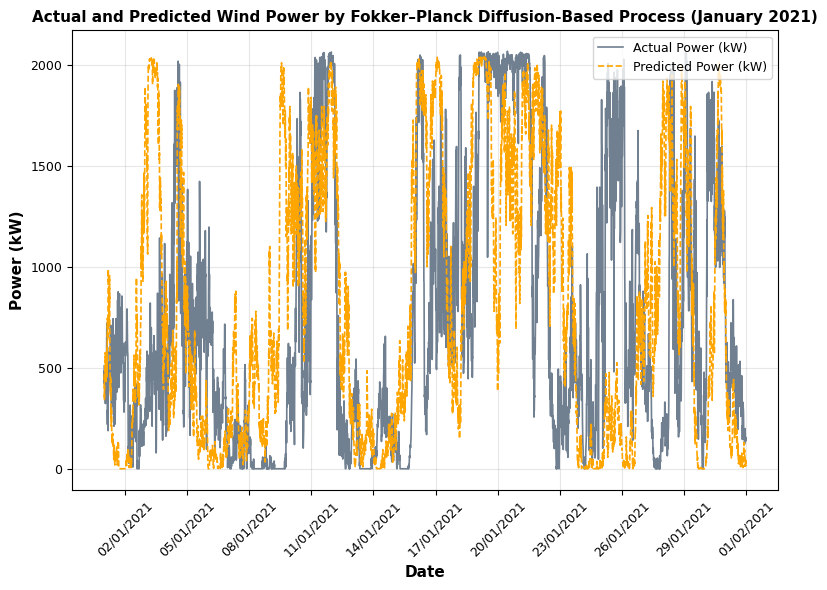

In [ ]:



# =====================================================
# Prepare Data
# =====================================================
X1 = df_simulated_FPDI[['Wind speed (m/s)']]
y1 = WindT2021_Jan['Power (kW)']
y_pred1 = model.predict(X1)

result_df_fkpd = df_simulated_FPDI[['Date and time']].copy()
result_df_fkpd['Date and time'] = pd.to_datetime(result_df_fkpd['Date and time'])
result_df_fkpd['Actual Power (kW)'] = y1.values
result_df_fkpd['Predicted Power (kW)'] = y_pred1

# =====================================================
# Plot — MATCHED VISUALIZATION STYLE
# =====================================================
plt.figure(figsize=(8, 6))

plt.plot(
    result_df_fkpd['Date and time'],
    result_df_fkpd['Actual Power (kW)'],
    color='slategrey',
    linewidth=1.2,
    label='Actual Power (kW)'
)

plt.plot(
    result_df_fkpd['Date and time'],
    result_df_fkpd['Predicted Power (kW)'],
    color='orange',
    linestyle='--',
    linewidth=1.2,
    label='Predicted Power (kW)'
)

# ---- Date formatting ----
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

# =====================================================
# Titles and Labels
# =====================================================
plt.title(
    'Actual and Predicted Wind Power by Fokker–Planck Diffusion-Based Process (January 2021)',
    fontsize=11,
    fontweight='bold'
)

plt.xlabel('Date', fontsize=11, fontweight='bold')
plt.ylabel('Power (kW)', fontsize=11, fontweight='bold')

plt.xticks(fontsize=9, rotation=45)
plt.yticks(fontsize=9)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=9, loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Area under the curves (kWh)
dt_hours = 10 / 60
area_actual = np.trapz(result_df_fkpd['Actual Power (kW)'], dx=dt_hours)
area_predicted = np.trapz(result_df_fkpd['Predicted Power (kW)'], dx=dt_hours)

print(f"Total Actual Energy: {area_actual:.2f} kWh")
print(f"Total Predicted Energy: {area_predicted:.2f} kWh")

Total Actual Energy: 560225.40 kWh
Total Predicted Energy: 612723.50 kWh


/tmp/ipython-input-1484902745.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_actual = np.trapz(result_df_fkpd['Actual Power (kW)'], dx=dt_hours)
/tmp/ipython-input-1484902745.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area_predicted = np.trapz(result_df_fkpd['Predicted Power (kW)'], dx=dt_hours)


In [ ]:
####

#### CDF Analysis of Wind Power and Wind Speed

In [ ]:
WindT2021_Jan_Complete = WindT2021_Jan.join([
    df_simulated_FKP[['Wind speed (m/s)']].rename(columns={
        'Wind speed (m/s)': 'FKP_Wind speed (m/s)'
    }),
    df_simulated_FPDI[['Wind speed (m/s)']].rename(columns={
        'Wind speed (m/s)': 'FPDI_Wind speed (m/s)'
    }),
    df_simulated_OU[['Wind speed (m/s)']].rename(columns={
        'Wind speed (m/s)': 'OU_Wind speed (m/s)'
    }),
    result_df_fkp[['Predicted Power (kW)']].rename(columns={
        'Predicted Power (kW)': 'FKP_Predicted Power (kW)'
    }),

    result_df_fkpd[['Predicted Power (kW)']].rename(columns={
        'Predicted Power (kW)': 'FKPD_Predicted Power (kW)'
    }),


     result_df_ou[['Predicted Power (kW)']].rename(columns={
        'Predicted Power (kW)': 'OU_Predicted Power (kW)'
    })
])



WindT2021_Jan_Complete

,Date and time,Wind speed (m/s),Power (kW),Month,Year,FKP_Wind speed (m/s),FPDI_Wind speed (m/s),OU_Wind speed (m/s),FKP_Predicted Power (kW),FKPD_Predicted Power (kW),OU_Predicted Power (kW)
0,2021-01-01 00:00:00,6.204656,510.487854,1,2021,6.204656,6.204656,6.204656,470.885742,470.885742,470.885742
1,2021-01-01 00:10:00,5.858888,421.761902,1,2021,6.375953,5.620305,6.118853,520.524841,339.545441,450.046722
2,2021-01-01 00:20:00,6.069038,486.600555,1,2021,6.327719,5.736391,5.906488,499.414276,363.677673,403.096405
3,2021-01-01 00:30:00,5.918869,450.720245,1,2021,6.550459,6.121403,5.658608,563.307800,450.046722,351.580170
4,2021-01-01 00:40:00,5.408306,341.076813,1,2021,7.075230,6.035993,5.683195,719.066345,433.560150,358.503510
...,...,...,...,...,...,...,...,...,...,...,...
4459,2021-01-31 23:10:00,5.028050,146.059116,1,2021,1.369322,2.771307,6.946906,0.004231,12.337632,685.917114
4460,2021-01-31 23:20:00,5.116760,135.678171,1,2021,1.553089,3.219669,6.848206,0.016173,42.709412,654.924133
4461,2021-01-31 23:30:00,5.410994,155.834991,1,2021,1.862338,3.184286,6.624670,0.200174,41.399414,581.569031
4462,2021-01-31 23:40:00,5.159788,140.325806,1,2021,2.350089,2.747238,6.143123,1.760252,12.337632,456.749786


In [ ]:
WindT2021_Jan_Complete.columns

Index(['Date and time', 'Wind speed (m/s)', 'Power (kW)', 'Month', 'Year',
       'FKP_Wind speed (m/s)', 'FPDI_Wind speed (m/s)', 'OU_Wind speed (m/s)',
       'FKP_Predicted Power (kW)', 'FKPD_Predicted Power (kW)',
       'OU_Predicted Power (kW)'],
      dtype='object')


--- Intersection values for Wind speed (m/s) ---

--- Intersection values for FKP_Wind speed (m/s) ---

--- Intersection values for FPDI_Wind speed (m/s) ---

--- Intersection values for OU_Wind speed (m/s) ---


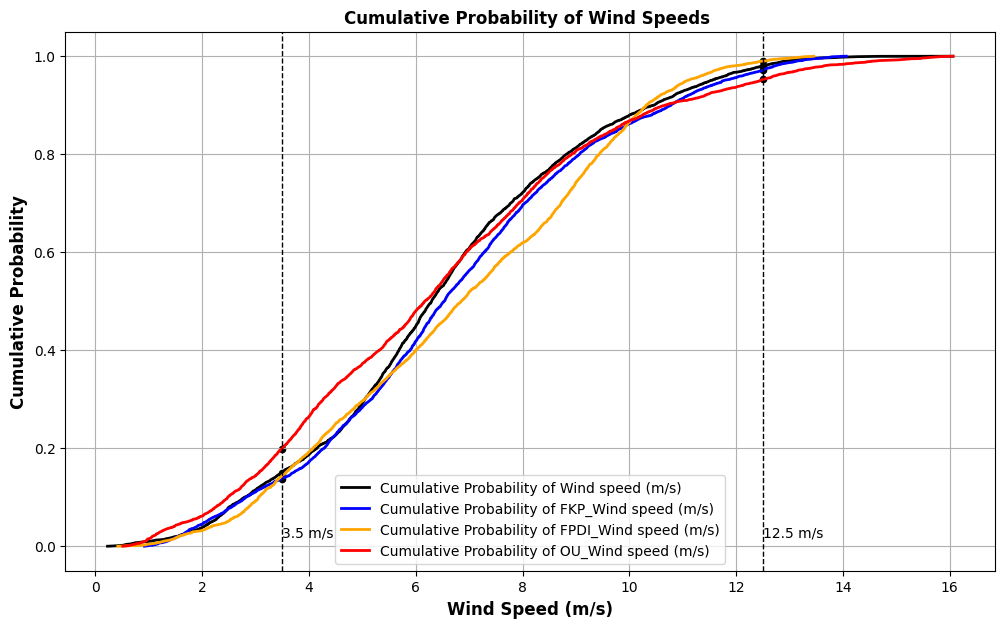

In [ ]:

# Assign fixed colors for each column
color_map = {
    "Wind speed (m/s)": "black",
    "FKP_Wind speed (m/s)": "blue",
    "FPDI_Wind speed (m/s)": "Orange",
    "OU_Wind speed (m/s)": "red"
}

wind_columns = [
    "Wind speed (m/s)",
    "FKP_Wind speed (m/s)",
    "FPDI_Wind speed (m/s)",
    "OU_Wind speed (m/s)"
]

thresholds = [3.5, 12.5]

plt.figure(figsize=(12, 7))

for col in wind_columns:
    data1 = WindT2021_Jan_Complete[col].dropna().values
    sorted_data = np.sort(data1)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)


    plt.plot(sorted_data, cdf, color=color_map[col], linewidth=2, label=f"Cumulative Probability of {col}")

    print(f"\n--- Intersection values for {col} ---")

    for t in thresholds:
        idx = np.searchsorted(sorted_data, t, side='right')
        cdf_value = idx / len(sorted_data)


        plt.scatter(t, cdf_value, color='black', s=20)


for t in thresholds:
    plt.axvline(x=t, color='black', linestyle='--', linewidth=1)
    plt.text(t, 0.02, f"{t} m/s", rotation=0, color='black')


plt.xlabel("Wind Speed (m/s)", fontsize=12, fontweight='bold')
plt.ylabel("Cumulative Probability", fontsize=12, fontweight='bold')

plt.title("Cumulative Probability of Wind Speeds ", fontsize=12, fontweight='bold')
plt.grid(True)
plt.legend()
plt.show()


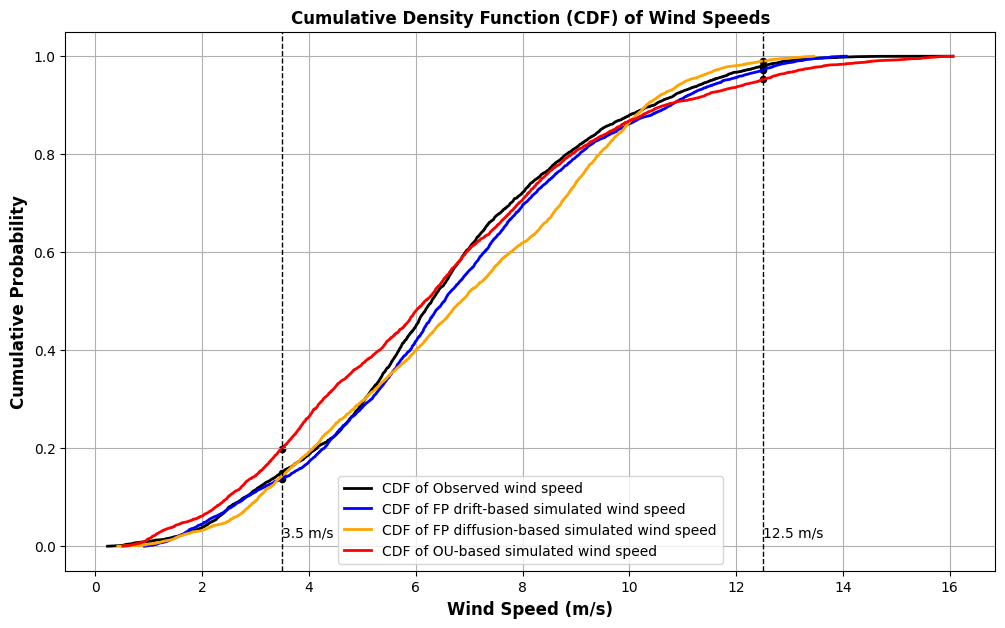

In [ ]:
# Fixed colors for each column
color_map = {
    "Wind speed (m/s)": "black",
    "FKP_Wind speed (m/s)": "blue",
    "FPDI_Wind speed (m/s)": "orange",
    "OU_Wind speed (m/s)": "red"
}

# Data columns
wind_columns = [
    "Wind speed (m/s)",
    "FKP_Wind speed (m/s)",
    "FPDI_Wind speed (m/s)",
    "OU_Wind speed (m/s)"
]

# Custom legend names (✔ corrected key)
legend_name_map = {
    "Wind speed (m/s)": "Observed wind speed",
    "FKP_Wind speed (m/s)": "FP drift-based simulated wind speed",
    "FPDI_Wind speed (m/s)": "FP diffusion-based simulated wind speed",
    "OU_Wind speed (m/s)": "OU-based simulated wind speed"
}

thresholds = [3.5, 12.5]

plt.figure(figsize=(12, 7))

for col in wind_columns:
    data = WindT2021_Jan_Complete[col].dropna().values
    sorted_data = np.sort(data)

    # Empirical cumulative distribution
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    plt.plot(
        sorted_data,
        cdf,
        color=color_map[col],
        linewidth=2,
        label=f"CDF of {legend_name_map[col]}"
    )

    # Threshold intersection points
    for t in thresholds:
        idx = np.searchsorted(sorted_data, t, side='right')
        cdf_value = idx / len(sorted_data)
        plt.scatter(t, cdf_value, color='black', s=20)

# Vertical threshold lines
for t in thresholds:
    plt.axvline(x=t, color='black', linestyle='--', linewidth=1)
    plt.text(t, 0.02, f"{t} m/s", color='black')

plt.xlabel("Wind Speed (m/s)", fontsize=12, fontweight='bold')
plt.ylabel("Cumulative Probability", fontsize=12, fontweight='bold')
plt.title("Cumulative Density Function (CDF) of Wind Speeds", fontsize=12, fontweight='bold')

plt.grid(True)
plt.legend()
plt.show()


In [ ]:


wind_columns = [
    "Wind speed (m/s)",
    "FKP_Wind speed (m/s)",
    "FPDI_Wind speed (m/s)",
    "OU_Wind speed (m/s)"
]

thresholds = [3.5, 12.5]

for col in wind_columns:
    data = WindT2021_Jan_Complete[col].dropna().values
    sorted_data = np.sort(data)
    N = len(sorted_data)

    print(f"\n--- Percentages for {col} ---")

    for t in thresholds:
        count_below = np.searchsorted(sorted_data, t, side='right')
        percentage = (count_below / N) * 100
        print(f"Percentage below {t} m/s: {percentage:.2f}%")



--- Percentages for Wind speed (m/s) ---
Percentage below 3.5 m/s: 15.05%
Percentage below 12.5 m/s: 98.01%

--- Percentages for FKP_Wind speed (m/s) ---
Percentage below 3.5 m/s: 13.82%
Percentage below 12.5 m/s: 97.13%

--- Percentages for FPDI_Wind speed (m/s) ---
Percentage below 3.5 m/s: 14.47%
Percentage below 12.5 m/s: 98.99%

--- Percentages for OU_Wind speed (m/s) ---
Percentage below 3.5 m/s: 19.91%
Percentage below 12.5 m/s: 95.27%



--- Intersection values for Power (kW) ---

--- Intersection values for FKP_Predicted Power (kW) ---

--- Intersection values for FKPD_Predicted Power (kW) ---

--- Intersection values for OU_Predicted Power (kW) ---


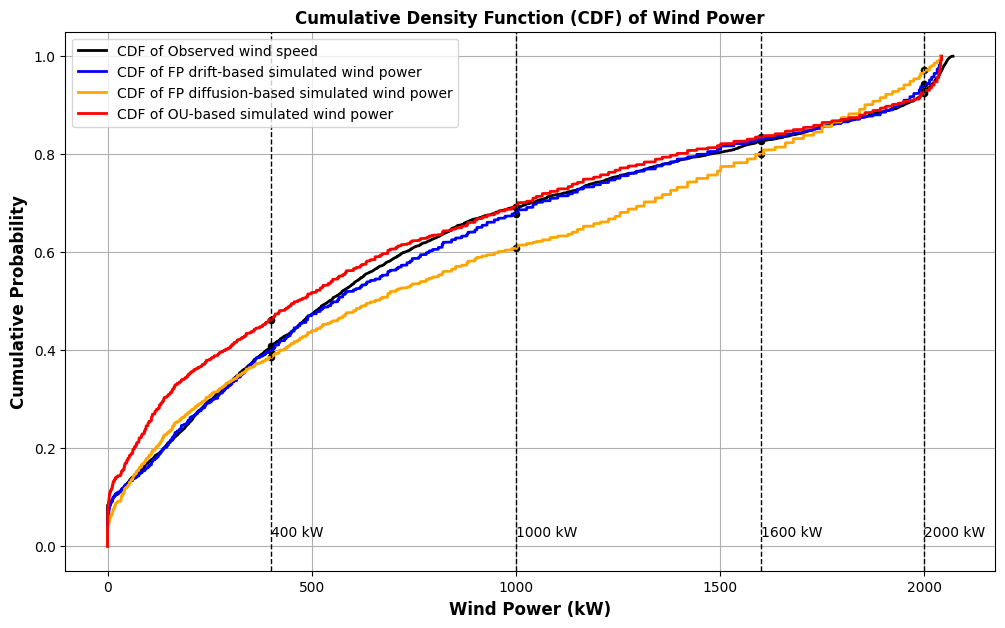

In [ ]:
# Assign fixed colors for each column
color_map = {
    "Power (kW)": "black",
    "FKP_Predicted Power (kW)": "blue",
    "FKPD_Predicted Power (kW)": "orange",
    "OU_Predicted Power (kW)": "red"
}


Power_columns = [
    "Power (kW)",
    "FKP_Predicted Power (kW)",
     "FKPD_Predicted Power (kW)",
    "OU_Predicted Power (kW)"
]



# Custom legend names (✔ corrected key)
legend_name_map = {
    "Power (kW)": "Observed wind speed",
    "FKP_Predicted Power (kW)": "FP drift-based simulated wind power",
    "FKPD_Predicted Power (kW)": "FP diffusion-based simulated wind power",
    "OU_Predicted Power (kW)": "OU-based simulated wind power"
}






thresholds = [400, 1000, 1600, 2000]

plt.figure(figsize=(12, 7))

for col in Power_columns:
    data = WindT2021_Jan_Complete[col].dropna().values
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)


    plt.plot(sorted_data, cdf, color=color_map[col], linewidth=2, label=f"CDF of {legend_name_map[col]}")

    print(f"\n--- Intersection values for {col} ---")

    for t in thresholds:
        idx = np.searchsorted(sorted_data, t, side='right')
        cdf_value = idx / len(sorted_data)


        plt.scatter(t, cdf_value, color='black', s=20)


for t in thresholds:
    plt.axvline(x=t, color='black', linestyle='--', linewidth=1)
    plt.text(t, 0.02, f"{t} kW", rotation=0, color='black')





plt.xlabel("Wind Power (kW)", fontsize=12, fontweight='bold')
plt.ylabel("Cumulative Probability", fontsize=12, fontweight='bold')
plt.title("Cumulative Density Function (CDF) of Wind Power", fontsize=12, fontweight='bold')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
Power_columns = [
    "Power (kW)",
    "FKP_Predicted Power (kW)",
    "FKPD_Predicted Power (kW)",
    "OU_Predicted Power (kW)"
]

thresholds = [400, 1000, 1600,2000]

for col in Power_columns:
    data = WindT2021_Jan_Complete[col].dropna().values
    sorted_data = np.sort(data)
    N = len(sorted_data)

    print(f"\n--- Percentages for {col} ---")

    for t in thresholds:
        count_below = np.searchsorted(sorted_data, t, side='right')
        percentage = (count_below / N) * 100
        print(f"Percentage below {t} kW: {percentage:.2f}%")


--- Percentages for Power (kW) ---
Percentage below 400 kW: 40.82%
Percentage below 1000 kW: 69.24%
Percentage below 1600 kW: 82.71%
Percentage below 2000 kW: 92.59%

--- Percentages for FKP_Predicted Power (kW) ---
Percentage below 400 kW: 39.87%
Percentage below 1000 kW: 67.81%
Percentage below 1600 kW: 82.97%
Percentage below 2000 kW: 94.35%

--- Percentages for FKPD_Predicted Power (kW) ---
Percentage below 400 kW: 38.53%
Percentage below 1000 kW: 60.78%
Percentage below 1600 kW: 79.97%
Percentage below 2000 kW: 97.13%

--- Percentages for OU_Predicted Power (kW) ---
Percentage below 400 kW: 46.21%
Percentage below 1000 kW: 69.20%
Percentage below 1600 kW: 83.49%
Percentage below 2000 kW: 92.99%
